#FPL Data Analysis and Player Clustering

###Context



Fantasy Premier League(FPL) is a points-based game where you select a team consisting of players in the English Premier League(top division football league in England) based on certain constraints like budget etc., and your team accumulates points depending on the real world performance of players each gameweek.

Selecting a well-scoring team while spending as little as possible is a daunting task for many, even if they watch football regularly. This is mostly because the points system is purely based on stats, which are often hidden behind the actual performance of the player. That is, just because a player is effective in a game does not mean that the player accumulates good FPL points in the game.

I am going to attempt to build a solution using a clustering-based approach to group players into different categories and ultimately to suggest the most cost-effective team each gameweek based on the the players' previous performances in a season.

A more real world application of such a solution would be in actual sports clubs where identifying players with high potential and signing them for a cost as low as possible is very crucial to the long term success of the team not just on the pitch, but on the business side as well.

###Objective

The objective of this project is to try and use various clustering techniques to group players based on the FPL dataset and identify a cost-effective team.

###Data collection and integration

In [ ]:
#importing the necessary libraries

import requests, json
from pprint import pprint
import pandas as pd
pd.set_option('display.max_columns', None)
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import warnings
warnings.filterwarnings('ignore')

np.random.seed(1)

In [ ]:
# base url for all FPL API endpoints
base_url = 'https://fantasy.premierleague.com/api/'

# get data from bootstrap-static endpoint
r = requests.get(base_url+'bootstrap-static/').json()

# show the top level fields
pprint(r, indent=2, depth=1, compact=True)

{ 'element_stats': [...],
  'element_types': [...],
  'elements': [...],
  'events': [...],
  'game_settings': {...},
  'phases': [...],
  'teams': [...],
  'total_players': 10872691}


In [ ]:
players = r['elements']
pprint(players[0])

{'assists': 0,
 'bonus': 0,
 'bps': 0,
 'chance_of_playing_next_round': 0,
 'chance_of_playing_this_round': 0,
 'clean_sheets': 0,
 'clean_sheets_per_90': 0,
 'code': 232223,
 'corners_and_indirect_freekicks_order': None,
 'corners_and_indirect_freekicks_text': '',
 'cost_change_event': 0,
 'cost_change_event_fall': 0,
 'cost_change_start': -1,
 'cost_change_start_fall': 1,
 'creativity': '0.0',
 'creativity_rank': 691,
 'creativity_rank_type': 72,
 'direct_freekicks_order': None,
 'direct_freekicks_text': '',
 'dreamteam_count': 0,
 'element_type': 4,
 'ep_next': '0.0',
 'ep_this': '0.0',
 'event_points': 0,
 'expected_assists': '0.00',
 'expected_assists_per_90': 0,
 'expected_goal_involvements': '0.00',
 'expected_goal_involvements_per_90': 0,
 'expected_goals': '0.00',
 'expected_goals_conceded': '0.00',
 'expected_goals_conceded_per_90': 0,
 'expected_goals_per_90': 0,
 'first_name': 'Folarin',
 'form': '0.0',
 'form_rank': 601,
 'form_rank_type': 56,
 'goals_conceded': 0,
 'goals

In [ ]:
player_data = pd.json_normalize(players)
player_data = pd.concat([player_data[['first_name','second_name','team']], player_data.drop(columns=['first_name','second_name','team'])], axis=1)
player_data.head()

,first_name,second_name,team,chance_of_playing_next_round,chance_of_playing_this_round,code,cost_change_event,cost_change_event_fall,cost_change_start,cost_change_start_fall,dreamteam_count,element_type,ep_next,ep_this,event_points,form,id,in_dreamteam,news,news_added,now_cost,photo,points_per_game,selected_by_percent,special,squad_number,status,team_code,total_points,transfers_in,transfers_in_event,transfers_out,transfers_out_event,value_form,value_season,web_name,minutes,goals_scored,assists,clean_sheets,goals_conceded,own_goals,penalties_saved,penalties_missed,yellow_cards,red_cards,saves,bonus,bps,influence,creativity,threat,ict_index,starts,expected_goals,expected_assists,expected_goal_involvements,expected_goals_conceded,influence_rank,influence_rank_type,creativity_rank,creativity_rank_type,threat_rank,threat_rank_type,ict_index_rank,ict_index_rank_type,corners_and_indirect_freekicks_order,corners_and_indirect_freekicks_text,direct_freekicks_order,direct_freekicks_text,penalties_order,penalties_text,expected_goals_per_90,saves_per_90,expected_assists_per_90,expected_goal_involvements_per_90,expected_goals_conceded_per_90,goals_conceded_per_90,now_cost_rank,now_cost_rank_type,form_rank,form_rank_type,points_per_game_rank,points_per_game_rank_type,selected_rank,selected_rank_type,starts_per_90,clean_sheets_per_90
0,Folarin,Balogun,1,0.0,0.0,232223,0,0,-1,1,0,4,0.0,0.0,0,0.0,1,False,Transferred to Monaco,2023-08-31T08:55:15.272751Z,44,232223.jpg,0.0,0.2,False,None,u,3,0,10024,0,63575,29,0.0,0.0,Balogun,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0.00,0.00,0.00,0.00,698,71,691,72,664,70,700,72,NaN,,NaN,,NaN,,0.00,0.0,0.00,0.00,0.00,0.00,561,105,601,56,712,77,347,51,0.00,0.00
1,Cédric,Alves Soares,1,NaN,NaN,58822,0,0,-2,2,0,2,1.0,0.5,0,0.0,2,False,,None,38,58822.jpg,1.0,0.5,False,None,a,3,3,65610,1379,64782,1581,0.0,0.8,Cédric,59,0,0,0,0,0,0,0,0,0,0,0,15,2.0,4.3,0.0,0.6,0,0.00,0.02,0.02,0.39,525,189,465,173,483,178,519,184,NaN,,NaN,,NaN,,0.00,0.0,0.03,0.03,0.59,0.00,849,271,396,135,454,156,244,97,0.00,0.00
2,Mohamed,Elneny,1,100.0,100.0,153256,0,0,-1,1,0,3,1.0,0.5,0,0.0,3,False,,2023-12-30T22:30:09.113694Z,44,153256.jpg,2.0,0.1,False,None,a,3,6,13549,15,20519,43,0.0,1.4,M.Elneny,25,0,1,0,0,0,0,0,0,0,0,0,16,4.0,2.1,10.0,1.6,0,0.08,0.01,0.09,0.13,512,228,477,231,444,220,507,229,NaN,,NaN,,NaN,,0.29,0.0,0.04,0.33,0.47,0.00,532,316,588,198,303,125,474,155,0.00,0.00
3,Fábio,Ferreira Vieira,1,100.0,100.0,438098,0,0,-1,1,0,3,1.3,0.8,0,0.3,4,False,,2023-12-07T12:00:08.489004Z,54,438098.jpg,2.2,0.1,False,None,a,3,24,11762,7,19189,18,0.1,4.4,Fábio Vieira,290,1,3,1,2,0,0,0,0,1,0,0,67,82.8,88.8,85.0,25.5,2,1.25,0.64,1.89,1.83,405,172,313,172,292,150,376,169,NaN,,NaN,,4.0,,0.39,0.0,0.20,0.59,0.57,0.62,122,74,358,169,281,116,449,143,0.62,0.31
4,Gabriel,dos Santos Magalhães,1,100.0,100.0,226597,0,0,4,-4,3,2,5.2,4.7,1,4.2,5,True,,2024-03-18T22:00:08.938811Z,54,226597.jpg,4.1,28.4,False,None,a,3,134,3448014,33347,3414008,33955,0.8,24.8,Gabriel,2804,3,1,14,25,1,0,0,4,0,0,6,612,640.8,116.9,361.0,112.1,31,4.08,0.61,4.69,24.71,54,15,266,77,97,4,112,19,NaN,,NaN,,NaN,,0.13,0.0,0.02,0.15,0.79,0.80,117,13,51,14,44,6,9,2,1.00,0.45


In [ ]:
player_data_cols = ['first_name', 'second_name', 'team', 'chance_of_playing_this_round', 'chance_of_playing_next_round', 'element_type', 'ep_this', 'ep_next', 'form', 'now_cost', 'points_per_game', 'total_points', 'minutes', 'goals_scored', 'assists', 'clean_sheets', 'goals_conceded', 'saves', 'bonus', 'bps', 'influence', 'creativity', 'threat', 'starts', 'expected_goals', 'expected_assists', 'expected_goal_involvements', 'expected_goals_conceded', 'expected_goals_per_90', 'saves_per_90', 'expected_assists_per_90']
player_data = player_data[player_data_cols]

In [ ]:
player_data.head()

,first_name,second_name,team,chance_of_playing_this_round,chance_of_playing_next_round,element_type,ep_this,ep_next,form,now_cost,points_per_game,total_points,minutes,goals_scored,assists,clean_sheets,goals_conceded,saves,bonus,bps,influence,creativity,threat,starts,expected_goals,expected_assists,expected_goal_involvements,expected_goals_conceded,expected_goals_per_90,saves_per_90,expected_assists_per_90
0,Folarin,Balogun,1,0.0,0.0,4,0.0,0.0,0.0,44,0.0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0,0.00,0.00,0.00,0.00,0.00,0.0,0.00
1,Cédric,Alves Soares,1,NaN,NaN,2,0.5,1.0,0.0,38,1.0,3,59,0,0,0,0,0,0,15,2.0,4.3,0.0,0,0.00,0.02,0.02,0.39,0.00,0.0,0.03
2,Mohamed,Elneny,1,100.0,100.0,3,0.5,1.0,0.0,44,2.0,6,25,0,1,0,0,0,0,16,4.0,2.1,10.0,0,0.08,0.01,0.09,0.13,0.29,0.0,0.04
3,Fábio,Ferreira Vieira,1,100.0,100.0,3,0.8,1.3,0.3,54,2.2,24,290,1,3,1,2,0,0,67,82.8,88.8,85.0,2,1.25,0.64,1.89,1.83,0.39,0.0,0.20
4,Gabriel,dos Santos Magalhães,1,100.0,100.0,2,4.7,5.2,4.2,54,4.1,134,2804,3,1,14,25,0,6,612,640.8,116.9,361.0,31,4.08,0.61,4.69,24.71,0.13,0.0,0.02


In [ ]:
team_data = r['teams']
team_data = pd.DataFrame(team_data)
team_data = team_data[['id','name','short_name']]

In [ ]:
team_data.head()

,id,name,short_name
0,1,Arsenal,ARS
1,2,Aston Villa,AVL
2,3,Bournemouth,BOU
3,4,Brentford,BRE
4,5,Brighton,BHA


In [ ]:
position_data = r['element_types']
position_data = pd.DataFrame(position_data)
position_data = position_data[['id','singular_name','singular_name_short']]
position_data

,id,singular_name,singular_name_short
0,1,Goalkeeper,GKP
1,2,Defender,DEF
2,3,Midfielder,MID
3,4,Forward,FWD


In [ ]:
def get_team_name(x):
  return team_data[team_data['id']==x]['name']

def get_position_name(x):
  return position_data[position_data['id']==x]['singular_name']

In [ ]:
player_data['team_name'] = player_data['team'].map(team_data.set_index('id')['name'])
player_data['position'] = player_data['element_type'].map(position_data.set_index('id')['singular_name'])

In [ ]:
player_data[player_data['first_name']=='Marcus']

,first_name,second_name,team,chance_of_playing_this_round,chance_of_playing_next_round,element_type,ep_this,ep_next,form,now_cost,points_per_game,total_points,minutes,goals_scored,assists,clean_sheets,goals_conceded,saves,bonus,bps,influence,creativity,threat,starts,expected_goals,expected_assists,expected_goal_involvements,expected_goals_conceded,expected_goals_per_90,saves_per_90,expected_assists_per_90,team_name,position
9,Marcus,Oliveira Alencar,1,0.0,0.0,3,0.0,0.0,0.0,45,0.0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0,0.00,0.00,0.00,0.00,0.00,0.0,0.00,Arsenal,Midfielder
104,Marcus,Tavernier,3,0.0,0.0,3,0.0,0.0,1.2,50,3.1,87,2037,3,4,8,34,0,5,312,449.6,599.4,440.0,24,3.74,4.11,7.85,31.17,0.17,0.0,0.18,Bournemouth,Midfielder
263,Marcus,Bettinelli,7,100.0,100.0,1,-1.0,0.0,0.0,40,0.0,-1,0,0,0,0,0,0,0,-3,0.0,0.0,0.0,0,0.00,0.00,0.00,0.00,0.00,0.0,0.00,Chelsea,Goalkeeper
569,Marcus,Rashford,14,25.0,25.0,3,0.4,0.2,1.0,84,3.4,106,2242,7,3,7,36,0,0,323,447.2,357.6,667.0,26,7.06,2.80,9.86,48.09,0.28,0.0,0.11,Man Utd,Midfielder


In [ ]:
player_data = pd.concat( [player_data[['first_name',	'second_name', 'team_name', 'position']], player_data.drop(columns=['first_name',	'second_name', 'team_name', 'position', 'team', 'element_type'])], axis=1)
player_data.head()

,first_name,second_name,team_name,position,chance_of_playing_this_round,chance_of_playing_next_round,ep_this,ep_next,form,now_cost,points_per_game,total_points,minutes,goals_scored,assists,clean_sheets,goals_conceded,saves,bonus,bps,influence,creativity,threat,starts,expected_goals,expected_assists,expected_goal_involvements,expected_goals_conceded,expected_goals_per_90,saves_per_90,expected_assists_per_90
0,Folarin,Balogun,Arsenal,Forward,0.0,0.0,0.0,0.0,0.0,44,0.0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0,0.00,0.00,0.00,0.00,0.00,0.0,0.00
1,Cédric,Alves Soares,Arsenal,Defender,NaN,NaN,0.5,1.0,0.0,38,1.0,3,59,0,0,0,0,0,0,15,2.0,4.3,0.0,0,0.00,0.02,0.02,0.39,0.00,0.0,0.03
2,Mohamed,Elneny,Arsenal,Midfielder,100.0,100.0,0.5,1.0,0.0,44,2.0,6,25,0,1,0,0,0,0,16,4.0,2.1,10.0,0,0.08,0.01,0.09,0.13,0.29,0.0,0.04
3,Fábio,Ferreira Vieira,Arsenal,Midfielder,100.0,100.0,0.8,1.3,0.3,54,2.2,24,290,1,3,1,2,0,0,67,82.8,88.8,85.0,2,1.25,0.64,1.89,1.83,0.39,0.0,0.20
4,Gabriel,dos Santos Magalhães,Arsenal,Defender,100.0,100.0,4.7,5.2,4.2,54,4.1,134,2804,3,1,14,25,0,6,612,640.8,116.9,361.0,31,4.08,0.61,4.69,24.71,0.13,0.0,0.02


In [ ]:
gk_data = player_data[player_data['position']=='Goalkeeper'].reset_index()
def_data = player_data[player_data['position']=='Defender'].reset_index()
mid_data = player_data[player_data['position']=='Midfielder'].reset_index()
fwd_data = player_data[player_data['position']=='Forward'].reset_index()

positional_data = [gk_data, def_data, mid_data, fwd_data]

In [ ]:
#loading the previous gameweek's team
#prev_team = pd.read_csv('gw30_team.csv').drop(['Unnamed: 0'], axis=1)
#prev_team

#####CONCLUSION


*   Now we have a dataset named **player_data**
 which contains the details of all the players in the Premier League league this season and the relevant stats to study their performance in FPL.
*   We also have four sub-datasets, namely **gk_data**, **def_data**, **mid_data**, **fwd_data** for the details of players in each of those positions.
*   We have the previous gameweek's team in **prev_team**.



###Data Description

In [ ]:
player_data.head()

,first_name,second_name,team_name,position,chance_of_playing_this_round,chance_of_playing_next_round,ep_this,ep_next,form,now_cost,points_per_game,total_points,minutes,goals_scored,assists,clean_sheets,goals_conceded,saves,bonus,bps,influence,creativity,threat,starts,expected_goals,expected_assists,expected_goal_involvements,expected_goals_conceded,expected_goals_per_90,saves_per_90,expected_assists_per_90
0,Folarin,Balogun,Arsenal,Forward,0.0,0.0,0.0,0.0,0.0,44,0.0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0,0.00,0.00,0.00,0.00,0.00,0.0,0.00
1,Cédric,Alves Soares,Arsenal,Defender,NaN,NaN,0.5,1.0,0.0,38,1.0,3,59,0,0,0,0,0,0,15,2.0,4.3,0.0,0,0.00,0.02,0.02,0.39,0.00,0.0,0.03
2,Mohamed,Elneny,Arsenal,Midfielder,100.0,100.0,0.5,1.0,0.0,44,2.0,6,25,0,1,0,0,0,0,16,4.0,2.1,10.0,0,0.08,0.01,0.09,0.13,0.29,0.0,0.04
3,Fábio,Ferreira Vieira,Arsenal,Midfielder,100.0,100.0,0.8,1.3,0.3,54,2.2,24,290,1,3,1,2,0,0,67,82.8,88.8,85.0,2,1.25,0.64,1.89,1.83,0.39,0.0,0.20
4,Gabriel,dos Santos Magalhães,Arsenal,Defender,100.0,100.0,4.7,5.2,4.2,54,4.1,134,2804,3,1,14,25,0,6,612,640.8,116.9,361.0,31,4.08,0.61,4.69,24.71,0.13,0.0,0.02


In [ ]:
player_data.shape

(859, 31)

We have 838 rows and 31 columns.

In [ ]:
player_data.duplicated().sum()

0

There are no duplicate rows.

In [ ]:
(player_data.isnull().sum()/player_data.shape[0])*100

first_name                       0.000000
second_name                      0.000000
team_name                        0.000000
position                         0.000000
chance_of_playing_this_round    24.097788
chance_of_playing_next_round    23.748545
ep_this                          0.000000
ep_next                          0.000000
form                             0.000000
now_cost                         0.000000
points_per_game                  0.000000
total_points                     0.000000
minutes                          0.000000
goals_scored                     0.000000
assists                          0.000000
clean_sheets                     0.000000
goals_conceded                   0.000000
saves                            0.000000
bonus                            0.000000
bps                              0.000000
influence                        0.000000
creativity                       0.000000
threat                           0.000000
starts                           0

There are no missing values except for two columns.

Close to 24% of the data is missing for columns 'chance_of_playing_this_round' and 'chance_of_playing_next_round'.

Let's take a deeper look at that.

In [ ]:
print(f"Number of rows where 'chance_of_playing_this_round' is missing: {player_data[player_data['chance_of_playing_this_round'].isnull()].shape[0]}")
print(f"Number of rows where 'chance_of_playing_next_round' is missing: {player_data[player_data['chance_of_playing_next_round'].isnull()].shape[0]}")
print(f"Number of rows where 'chance_of_playing_this_round' and 'chance_of_playing_next_round' are missing: {player_data[(player_data['chance_of_playing_this_round'].isnull()) & (player_data['chance_of_playing_next_round'].isnull())].shape[0]}")

Number of rows where 'chance_of_playing_this_round' is missing: 207
Number of rows where 'chance_of_playing_next_round' is missing: 204
Number of rows where 'chance_of_playing_this_round' and 'chance_of_playing_next_round' are missing: 204


From the above observation we can understand that whenever 'chance_of_playing_next_round' is missing, 'chance_of_playing_this_round' is missing as well.

However, there are two rows where only 'chance_of_playing_this_round' is missing. Let's take a look at those rows.

In [ ]:
player_data[(player_data['chance_of_playing_this_round'].isnull()) & (~player_data['chance_of_playing_next_round'].isnull())]

,first_name,second_name,team_name,position,chance_of_playing_this_round,chance_of_playing_next_round,ep_this,ep_next,form,now_cost,points_per_game,total_points,minutes,goals_scored,assists,clean_sheets,goals_conceded,saves,bonus,bps,influence,creativity,threat,starts,expected_goals,expected_assists,expected_goal_involvements,expected_goals_conceded,expected_goals_per_90,saves_per_90,expected_assists_per_90
190,Jan Paul,van Hecke,Brighton,Defender,NaN,75.0,1.8,1.0,1.8,41,2.2,61,2368,0,0,5,38,0,3,454,631.8,176.4,175.0,26,1.42,0.93,2.35,37.22,0.05,0.0,0.04
672,Neco,Williams,Nott'm Forest,Defender,NaN,75.0,-0.2,1.0,0.8,43,1.5,39,1630,0,1,1,33,0,2,224,393.4,195.2,139.0,18,0.74,1.54,2.28,23.05,0.04,0.0,0.09
776,Timo,Werner,Spurs,Forward,NaN,0.0,3.6,0.0,1.8,63,3.5,46,808,2,4,0,16,0,5,173,179.0,239.0,305.0,10,3.81,2.93,6.74,11.06,0.42,0.0,0.33


Further investigation is needed to understand why data is missing from these two columns.

In [ ]:
player_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 859 entries, 0 to 858
Data columns (total 31 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   first_name                    859 non-null    object 
 1   second_name                   859 non-null    object 
 2   team_name                     859 non-null    object 
 3   position                      859 non-null    object 
 4   chance_of_playing_this_round  652 non-null    float64
 5   chance_of_playing_next_round  655 non-null    float64
 6   ep_this                       859 non-null    object 
 7   ep_next                       859 non-null    object 
 8   form                          859 non-null    object 
 9   now_cost                      859 non-null    int64  
 10  points_per_game               859 non-null    object 
 11  total_points                  859 non-null    int64  
 12  minutes                       859 non-null    int64  
 13  goals

It can be noticed that there are several columns of 'object' datatype which is supposed to be of a numerical datatype. Let's take a look at those columns one by one and try to convert it into an appropriate datatype.

In [ ]:
incorrect_dtype_cols = ['ep_this','ep_next','form','points_per_game','influence','creativity','threat','expected_goals','expected_assists','expected_goal_involvements','expected_goals_conceded']

In [ ]:
for col in incorrect_dtype_cols:
  print(f'{col}:\n')
  print(np.unique(player_data[col]),'\n')
  print('-'*100)

ep_this:

['-0.1' '-0.2' '-0.3' '-0.5' '-0.6' '-0.8' '-1.0' '0.0' '0.1' '0.2' '0.3'
 '0.4' '0.5' '0.6' '0.7' '0.8' '0.9' '1.0' '1.1' '1.2' '1.3' '1.4' '1.5'
 '1.6' '1.7' '1.8' '1.9' '11.3' '18.6' '2.0' '2.1' '2.2' '2.3' '2.4' '2.5'
 '2.6' '2.7' '2.8' '2.9' '3.0' '3.1' '3.2' '3.3' '3.4' '3.5' '3.6' '3.7'
 '3.8' '3.9' '4.0' '4.1' '4.2' '4.3' '4.4' '4.5' '4.6' '4.7' '4.8' '4.9'
 '5.0' '5.2' '5.3' '5.4' '5.5' '5.6' '5.7' '5.8' '5.9' '6.0' '6.2' '6.4'
 '6.7' '7.0' '7.2' '7.3' '7.4' '7.6' '7.7' '8.0' '8.2' '8.3' '8.4' '8.8'
 '9.0' '9.6'] 

----------------------------------------------------------------------------------------------------
ep_next:

['-0.1' '-0.2' '-0.3' '-0.5' '-0.6' '-0.8' '-1.0' '0.0' '0.1' '0.2' '0.3'
 '0.4' '0.5' '0.6' '0.7' '0.8' '0.9' '1.0' '1.1' '1.2' '1.3' '1.4' '1.5'
 '1.6' '1.7' '1.8' '1.9' '2.0' '2.1' '2.2' '2.3' '2.4' '2.5' '2.6' '2.7'
 '2.8' '2.9' '3.0' '3.1' '3.2' '3.3' '3.4' '3.5' '3.6' '3.7' '3.8' '3.9'
 '4.0' '4.1' '4.2' '4.3' '4.4' '4.5' '4.6' '4.7' '4.8' '

Having a look at the unique values in each column, we can say that they are floating point numbers stored as strings.

In [ ]:
for col in incorrect_dtype_cols:
  player_data[col] = player_data[col].astype('float64')

In [ ]:
player_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 859 entries, 0 to 858
Data columns (total 31 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   first_name                    859 non-null    object 
 1   second_name                   859 non-null    object 
 2   team_name                     859 non-null    object 
 3   position                      859 non-null    object 
 4   chance_of_playing_this_round  652 non-null    float64
 5   chance_of_playing_next_round  655 non-null    float64
 6   ep_this                       859 non-null    float64
 7   ep_next                       859 non-null    float64
 8   form                          859 non-null    float64
 9   now_cost                      859 non-null    int64  
 10  points_per_game               859 non-null    float64
 11  total_points                  859 non-null    int64  
 12  minutes                       859 non-null    int64  
 13  goals

In [ ]:
player_data.describe().T

,count,mean,std,min,25%,50%,75%,max
chance_of_playing_this_round,652.0,49.693252,49.049156,0.0,0.0,25.00,100.000,100.00
chance_of_playing_next_round,655.0,51.335878,48.517094,0.0,0.0,75.00,100.000,100.00
ep_this,859.0,1.029104,1.908682,-1.0,0.0,0.00,1.600,18.60
ep_next,859.0,0.934692,1.688742,-1.0,0.0,0.00,1.400,9.80
form,859.0,0.974040,1.604209,0.0,0.0,0.00,1.500,10.80
now_cost,859.0,47.636787,9.942063,37.0,43.0,45.00,50.000,141.00
points_per_game,859.0,1.518859,1.490160,0.0,0.0,1.30,2.500,7.50
total_points,859.0,33.096624,42.826029,-1.0,0.0,13.00,58.000,219.00
minutes,859.0,795.788126,952.286184,0.0,0.0,301.00,1476.000,3150.00
goals_scored,859.0,1.259604,2.810882,0.0,0.0,0.00,1.000,21.00


From the statistical description of the numerical data, we can understand that almost all the numerical features are skewed to the right. We will try to prove it later using density plots while doing univariate analysis.

In [ ]:
player_data.describe(include='O').T

,count,unique,top,freq
first_name,859,570,James,13
second_name,859,809,Traoré,4
team_name,859,20,Chelsea,59
position,859,4,Midfielder,371


The most commonly occuring position is 'Midfielder'. We will explore the categorical columns further during univariate analysis.

###Univariate Analysis

In [ ]:
player_data.columns

Index(['first_name', 'second_name', 'team_name', 'position',
       'chance_of_playing_this_round', 'chance_of_playing_next_round',
       'ep_this', 'ep_next', 'form', 'now_cost', 'points_per_game',
       'total_points', 'minutes', 'goals_scored', 'assists', 'clean_sheets',
       'goals_conceded', 'saves', 'bonus', 'bps', 'influence', 'creativity',
       'threat', 'starts', 'expected_goals', 'expected_assists',
       'expected_goal_involvements', 'expected_goals_conceded',
       'expected_goals_per_90', 'saves_per_90', 'expected_assists_per_90'],
      dtype='object')

In [ ]:
numerical_cols = ['chance_of_playing_this_round', 'chance_of_playing_next_round',
       'ep_this', 'ep_next', 'form', 'now_cost', 'points_per_game',
       'total_points', 'minutes', 'goals_scored', 'assists', 'clean_sheets',
       'goals_conceded', 'saves', 'bonus', 'bps', 'influence', 'creativity',
       'threat', 'starts', 'expected_goals', 'expected_assists',
       'expected_goal_involvements', 'expected_goals_conceded',
       'expected_goals_per_90', 'saves_per_90', 'expected_assists_per_90']

categorical_cols = ['team_name', 'position']

In [ ]:
def univariate_numerical(col):
  fig, ax = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios':(1,3)}, figsize=(7,4))
  sns.boxplot(data=player_data, x=col, ax=ax[0], color='yellow', showmeans=True)
  sns.histplot(data=player_data, x=col, kde=True, ax=ax[1])
  ax[1].axvline(player_data[col].mean(), linestyle='-', color='green')
  ax[1].axvline(player_data[col].median(), linestyle='-', color='black')
  plt.show()

chance_of_playing_this_round:



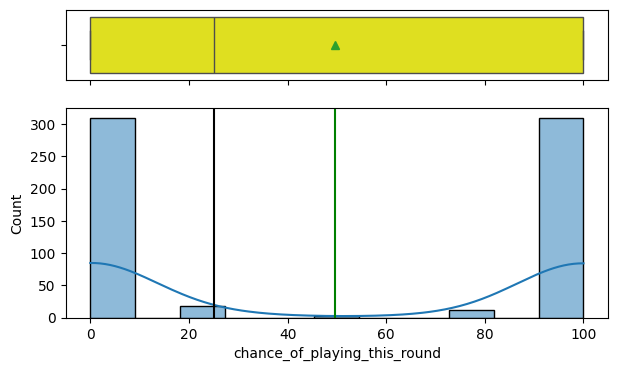


 ****************************************************************************************************
chance_of_playing_next_round:



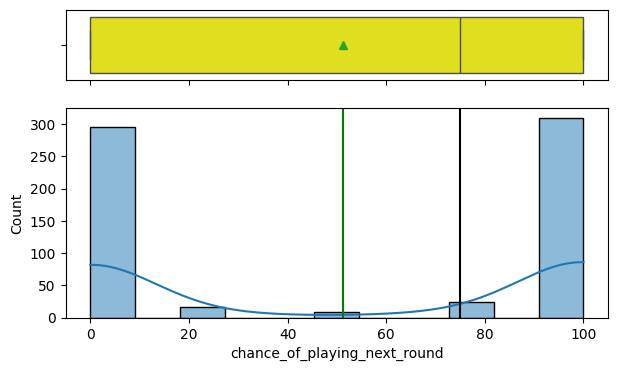


 ****************************************************************************************************
ep_this:



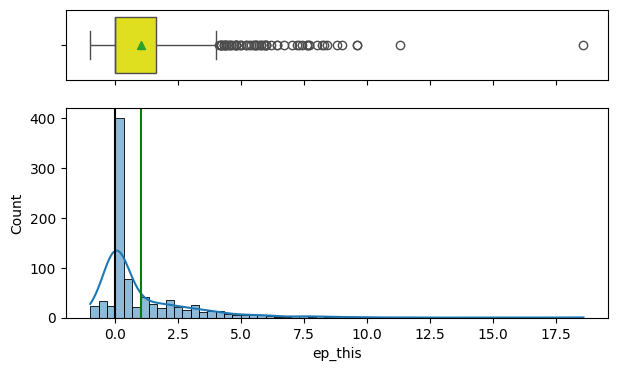


 ****************************************************************************************************
ep_next:



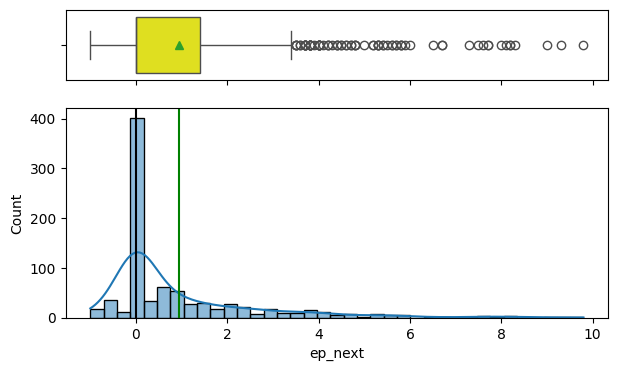


 ****************************************************************************************************
form:



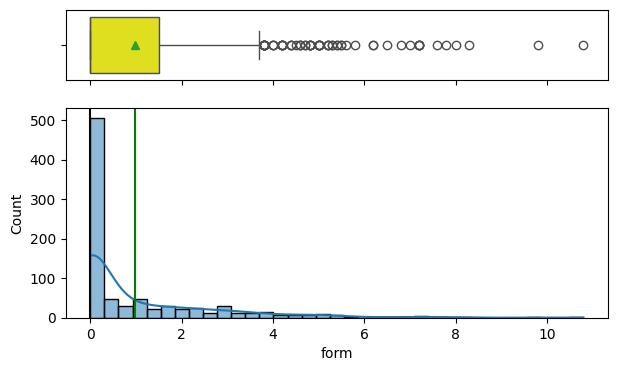


 ****************************************************************************************************
now_cost:



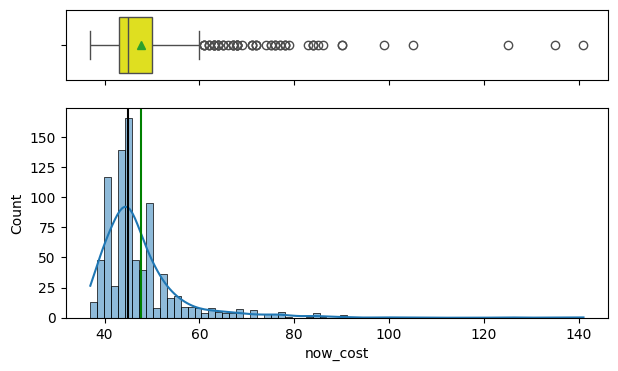


 ****************************************************************************************************
points_per_game:



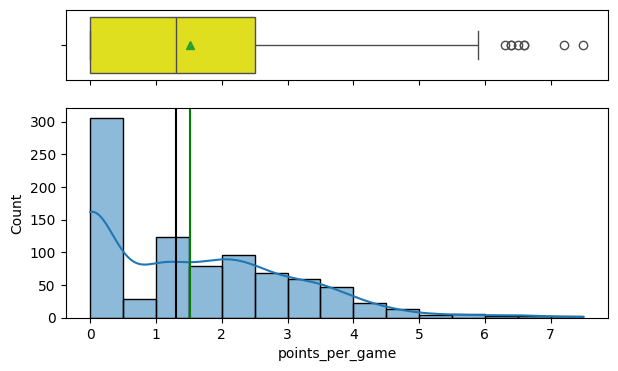


 ****************************************************************************************************
total_points:



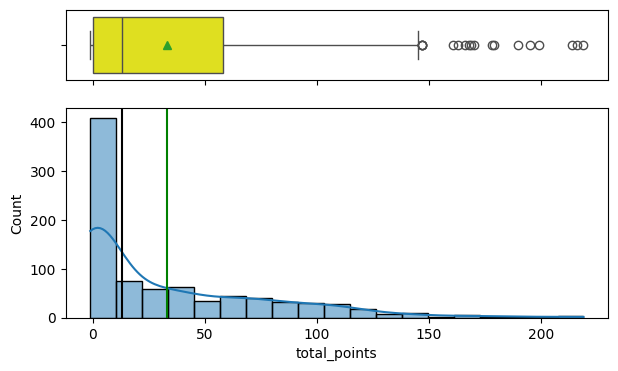


 ****************************************************************************************************
minutes:



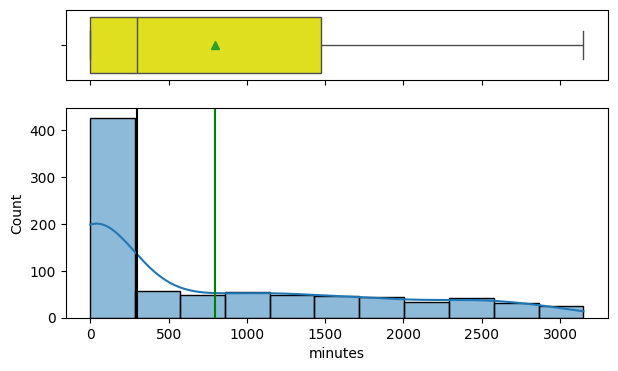


 ****************************************************************************************************
goals_scored:



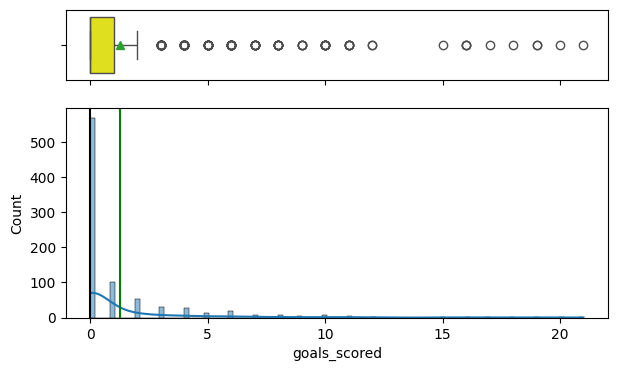


 ****************************************************************************************************
assists:



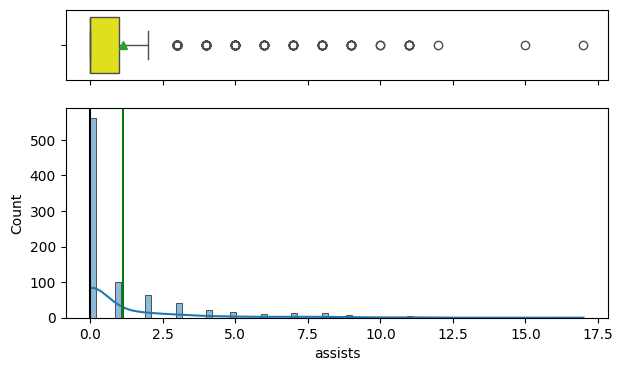


 ****************************************************************************************************
clean_sheets:



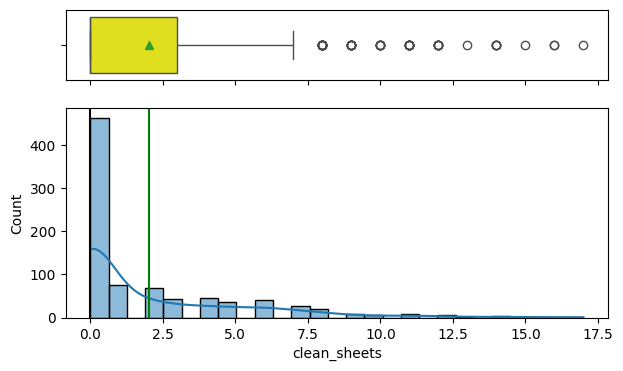


 ****************************************************************************************************
goals_conceded:



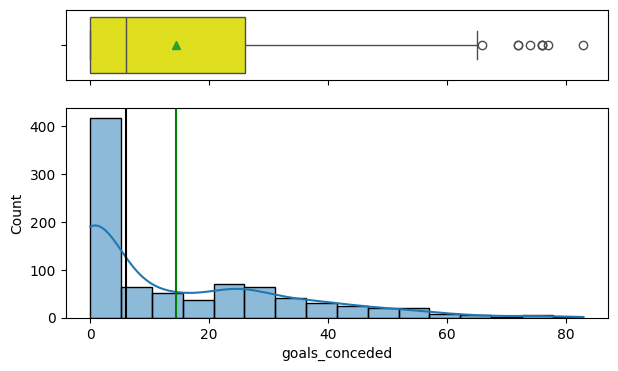


 ****************************************************************************************************
saves:



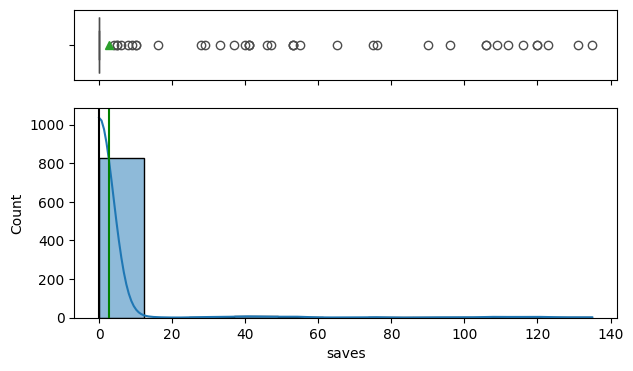


 ****************************************************************************************************
bonus:



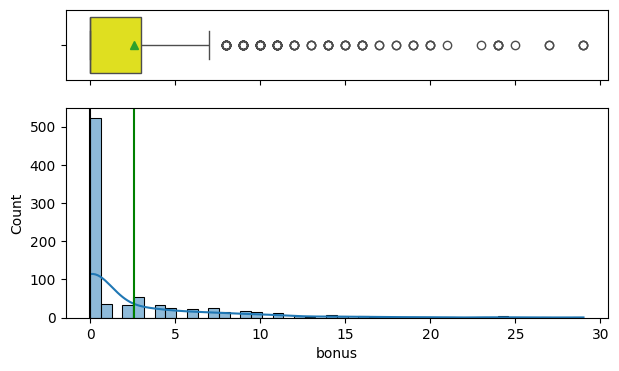


 ****************************************************************************************************
bps:



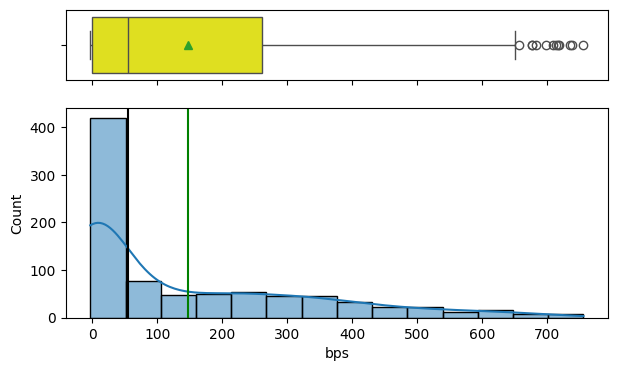


 ****************************************************************************************************
influence:



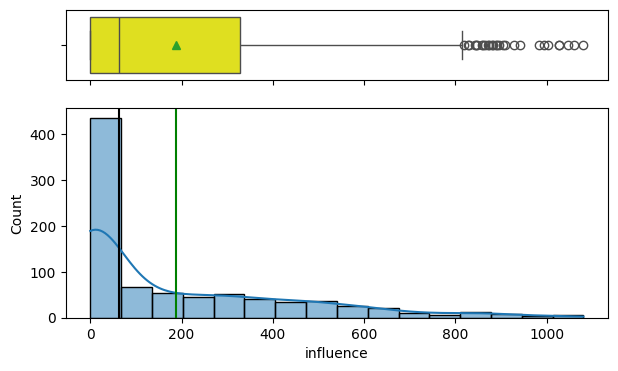


 ****************************************************************************************************
creativity:



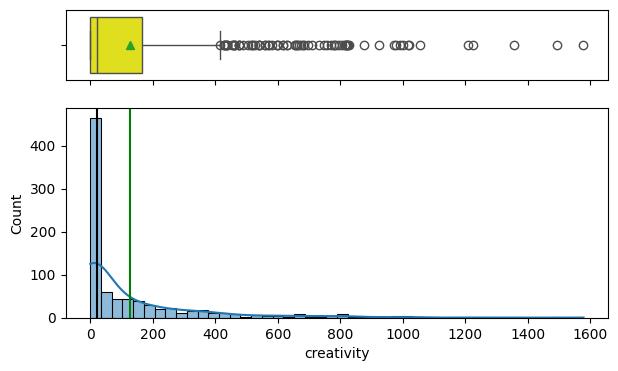


 ****************************************************************************************************
threat:



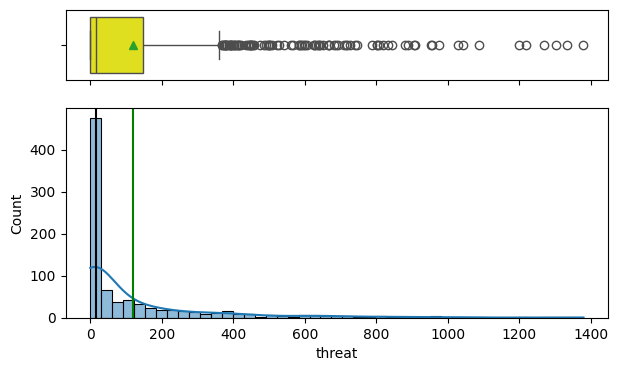


 ****************************************************************************************************
starts:



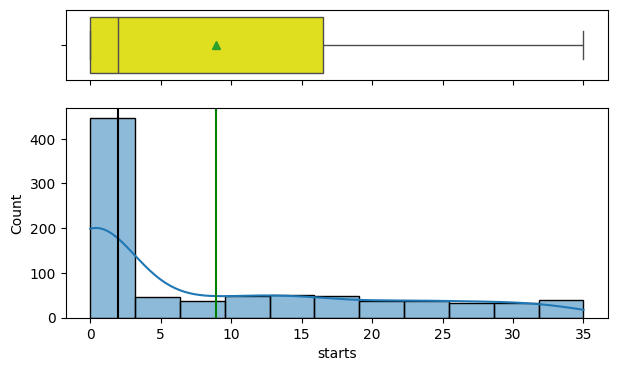


 ****************************************************************************************************
expected_goals:



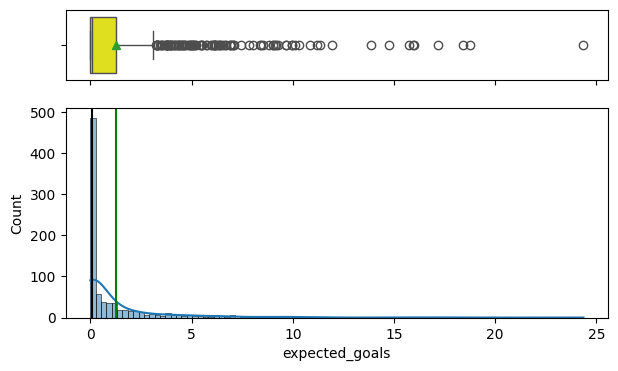


 ****************************************************************************************************
expected_assists:



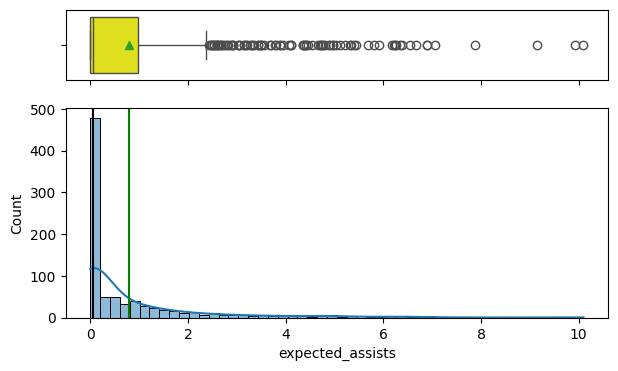


 ****************************************************************************************************
expected_goal_involvements:



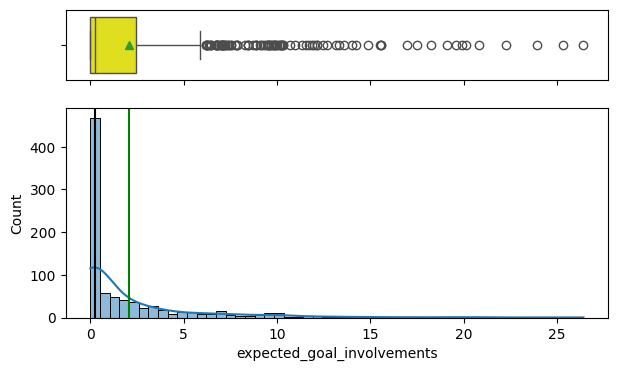


 ****************************************************************************************************
expected_goals_conceded:



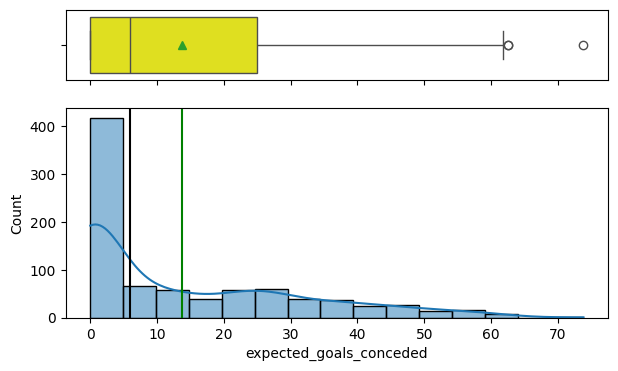


 ****************************************************************************************************
expected_goals_per_90:



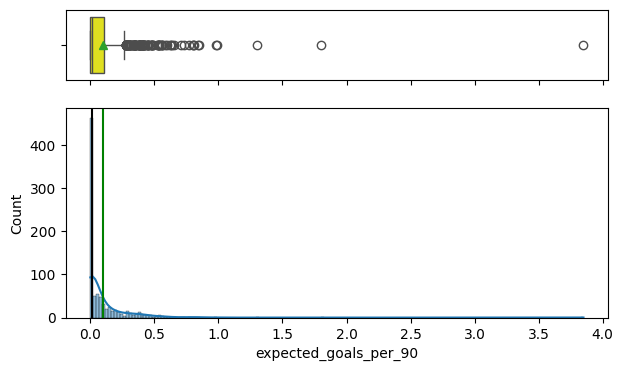


 ****************************************************************************************************
saves_per_90:



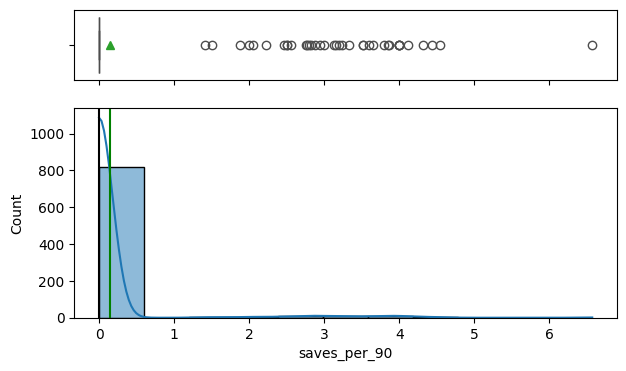


 ****************************************************************************************************
expected_assists_per_90:



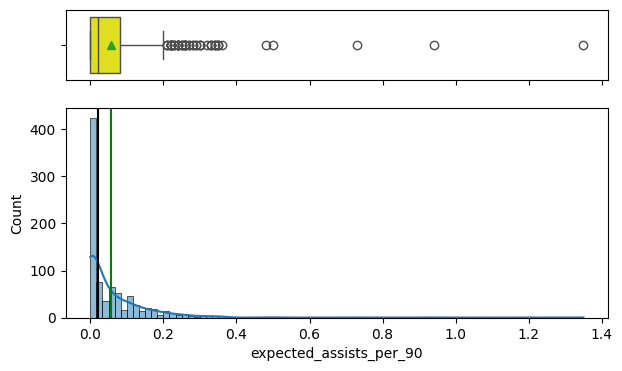


 ****************************************************************************************************


In [ ]:
for col in numerical_cols:
  print(f'{col}:\n')
  univariate_numerical(col)
  print('\n','*'*100)



*   **chance_of_playing_this_round**, **chance_of_playing_next_round**: The histogram is bimodal, indicating that there are two peaks close to 0 and 100. This implies that for majority of the players, the possibility of playing in the respective rounds are known(either will play(100) or won't play(0)).
*   **points_per_game**: There is a significant flat range between 1 and 2.25, indicating that amongst the players who score more than or equal to 1 point per game, there is a good chance for a selected player to have between 1 and 2.25 points per game.
*   All the other columns have a distribution skewed to the right.



In [ ]:
def univariate_categorical(col):
  print(f'{col}:\n')
  plt.figure(figsize=(5,4))
  sns.countplot(data=player_data, x=col, order=player_data[col].value_counts().index, hue=col)
  plt.xticks(rotation=90)
  plt.show()

team_name:



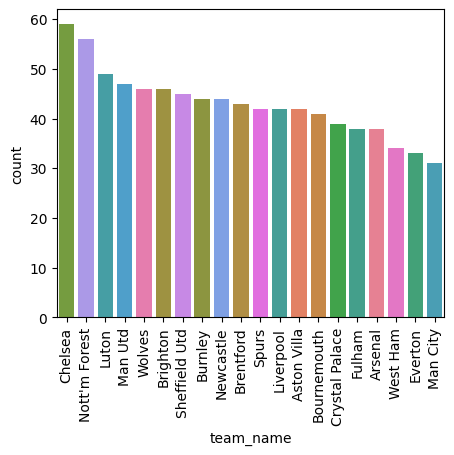

position:



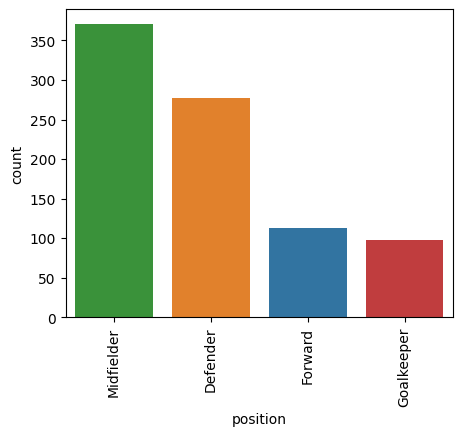

In [ ]:
for col in categorical_cols:
  univariate_categorical(col)

*   Nottingham Forest and Chelsea have the most number of players registered in FPL while Manchester City, Everton and West Ham United have the least.
*   Majority of the players registered in FPL are Midfielders, followed by Defenders, Forwards and Goalkeepers.

###Multivariate Analysis

In [ ]:
def highlight(val, th1, th2):
  if val>th1 and val!=1:
    color='green'
  elif val>th2 and val!=1:
    color='lightgreen'
  elif val<-(th1):
    color='red'
  elif val<-(th2):
    color='orange'
  else:
    color='white'
  return f'background-color: {color}'

player_data[numerical_cols].corr().style.applymap(highlight, th1=0.9, th2=0.7)

,chance_of_playing_this_round,chance_of_playing_next_round,ep_this,ep_next,form,now_cost,points_per_game,total_points,minutes,goals_scored,assists,clean_sheets,goals_conceded,saves,bonus,bps,influence,creativity,threat,starts,expected_goals,expected_assists,expected_goal_involvements,expected_goals_conceded,expected_goals_per_90,saves_per_90,expected_assists_per_90
chance_of_playing_this_round,1.000000,0.942386,0.572371,0.582614,0.604709,0.216961,0.569487,0.579006,0.603899,0.353463,0.381642,0.522474,0.556335,0.131263,0.437548,0.590525,0.576319,0.448040,0.408015,0.589200,0.356742,0.422428,0.417713,0.563000,0.198474,0.141847,0.230302
chance_of_playing_next_round,0.942386,1.000000,0.526101,0.577033,0.571088,0.226534,0.586033,0.579649,0.600445,0.369326,0.377841,0.514407,0.564053,0.122613,0.427310,0.579715,0.566783,0.451181,0.430550,0.585567,0.380226,0.420110,0.433483,0.563503,0.229974,0.139777,0.231002
ep_this,0.572371,0.526101,1.000000,0.916243,0.939709,0.424631,0.682403,0.739046,0.616281,0.598515,0.584268,0.679566,0.480187,0.128143,0.691696,0.687834,0.671739,0.604555,0.577327,0.614803,0.548778,0.601962,0.620251,0.526888,0.218648,0.102228,0.326556
ep_next,0.582614,0.577033,0.916243,1.000000,0.949230,0.434108,0.694572,0.747411,0.624003,0.595503,0.588419,0.713907,0.476718,0.126356,0.680869,0.684947,0.662729,0.607336,0.589681,0.621676,0.553409,0.602834,0.623863,0.515046,0.234167,0.103334,0.329466
form,0.604709,0.571088,0.939709,0.949230,1.000000,0.433619,0.728970,0.789249,0.687470,0.624408,0.612437,0.723570,0.568713,0.144950,0.715687,0.734931,0.724268,0.641176,0.620937,0.686244,0.580783,0.628959,0.653271,0.605256,0.238932,0.116839,0.332468
now_cost,0.216961,0.226534,0.424631,0.434108,0.433619,1.000000,0.553443,0.582071,0.382617,0.663785,0.565760,0.458114,0.257533,-0.016841,0.580596,0.452003,0.468691,0.549885,0.673751,0.384601,0.678774,0.584684,0.705178,0.292457,0.384327,-0.060883,0.381940
points_per_game,0.569487,0.586033,0.682403,0.694572,0.728970,0.553443,1.000000,0.894824,0.790831,0.702360,0.682197,0.760407,0.674757,0.192021,0.793457,0.837826,0.825683,0.692557,0.725778,0.786724,0.674692,0.693779,0.744612,0.714802,0.378642,0.207370,0.462790
total_points,0.579006,0.579649,0.739046,0.747411,0.789249,0.582071,0.894824,1.000000,0.903913,0.782595,0.770771,0.868294,0.774616,0.205944,0.886141,0.942719,0.934027,0.794421,0.818776,0.901761,0.760406,0.790184,0.842415,0.818993,0.319335,0.123871,0.405243
minutes,0.603899,0.600445,0.616281,0.624003,0.687470,0.382617,0.790831,0.903913,1.000000,0.536023,0.600438,0.826903,0.934581,0.279738,0.724022,0.965050,0.953062,0.695283,0.626166,0.996553,0.550187,0.665187,0.645775,0.959290,0.170098,0.184118,0.294432
goals_scored,0.353463,0.369326,0.598515,0.595503,0.624408,0.663785,0.702360,0.782595,0.536023,1.000000,0.676265,0.558361,0.445218,-0.078166,0.779992,0.595001,0.642428,0.626292,0.924009,0.538183,0.941279,0.648994,0.915094,0.475051,0.465504,-0.092255,0.343589


We can notice that there are no high negative correlations among the features. Let's take a look at the pairs having high correlations.

In [ ]:
high_correlation_pairs = []
decent_correlation_pairs = []
correlation_matrix = player_data[numerical_cols].corr()

# Iterate over the upper triangle of the correlation matrix
for i in range(len(correlation_matrix.columns)):
  for j in range(i+1, len(correlation_matrix.columns)):
    correlation_value = correlation_matrix.iloc[i, j]

    # Check if the absolute correlation value exceeds the threshold
    if abs(correlation_value) > 0.9:
      feature1 = correlation_matrix.columns[i]
      feature2 = correlation_matrix.columns[j]
      high_correlation_pairs.append((feature1, feature2))

high_correlation_pairs

[('chance_of_playing_this_round', 'chance_of_playing_next_round'),
 ('ep_this', 'ep_next'),
 ('ep_this', 'form'),
 ('ep_next', 'form'),
 ('total_points', 'minutes'),
 ('total_points', 'bps'),
 ('total_points', 'influence'),
 ('total_points', 'starts'),
 ('minutes', 'goals_conceded'),
 ('minutes', 'bps'),
 ('minutes', 'influence'),
 ('minutes', 'starts'),
 ('minutes', 'expected_goals_conceded'),
 ('goals_scored', 'threat'),
 ('goals_scored', 'expected_goals'),
 ('goals_scored', 'expected_goal_involvements'),
 ('goals_conceded', 'starts'),
 ('goals_conceded', 'expected_goals_conceded'),
 ('bps', 'influence'),
 ('bps', 'starts'),
 ('influence', 'starts'),
 ('influence', 'expected_goals_conceded'),
 ('creativity', 'expected_assists'),
 ('threat', 'expected_goals'),
 ('threat', 'expected_goal_involvements'),
 ('starts', 'expected_goals_conceded'),
 ('expected_goals', 'expected_goal_involvements')]

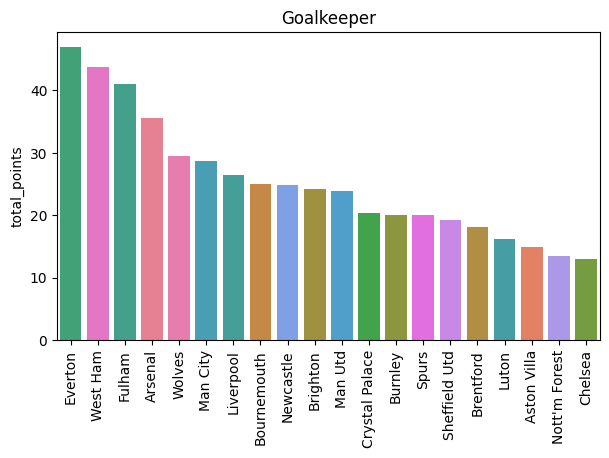

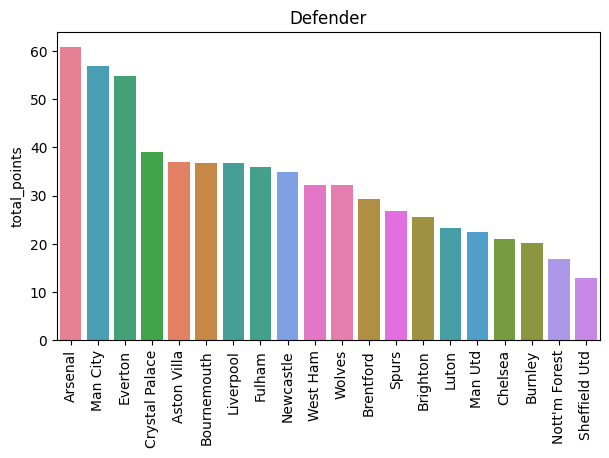

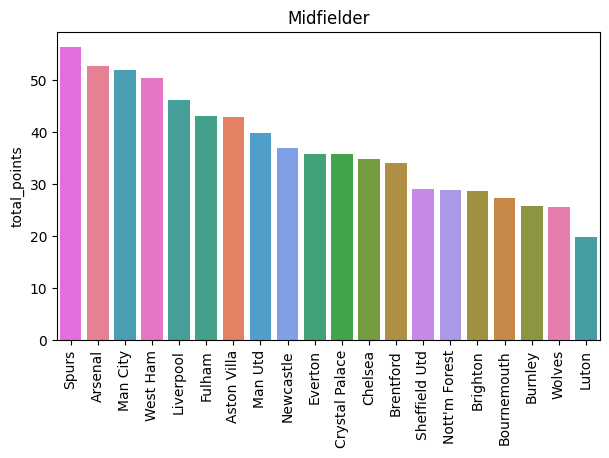

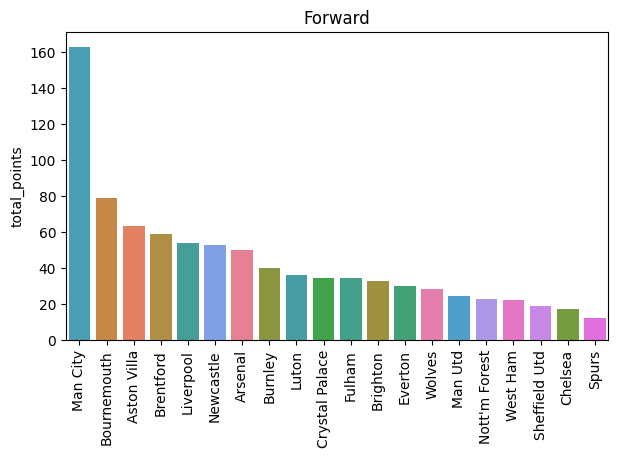

In [ ]:
for i,pos_data in enumerate(positional_data):
  plt.figure(figsize=(7,4))
  teams = np.unique(pos_data['team_name'])
  team_avg_points = pos_data.groupby('team_name')['total_points'].mean()
  sns.barplot(x=teams, y=team_avg_points, hue=teams, order=team_avg_points.sort_values(ascending=False).index)
  plt.xticks(rotation=90)
  plt.title(pos_data['position'][0])
  plt.show()

* Among goalkeepers- West Ham United, Fulham and Everton have the highest average points.
* Among defenders- Arsenal, Manchester City and Everton have the highest average points.
* Among midfielders- Tottenham Hotspurs, West Ham United and Arsenal have the highest average points.
* Among forwards- Manchester City is way ahead any other team in terms of average points, followed by Bournemouth and Aston Villa.
* It can be understood that when it comes to goalkeepers, certain lower ranked teams tend to have more average points. This could be because of the higher shots faced giving rise to more number of saves.

Let's take a look at the top 3 players from each position in terms of total points.

In [ ]:
for pos_data in positional_data:
  ranked_data = pos_data.sort_values(by='total_points', ascending=False)[['first_name','second_name','total_points']].reset_index()
  print(pos_data['position'][0],':\n')
  print(ranked_data[['first_name','second_name','total_points']].head(3))
  print('*'*100,'\n')

Goalkeeper :

  first_name  second_name  total_points
0     Jordan     Pickford           141
1      Bernd         Leno           124
2      David  Raya Martin           122
**************************************************************************************************** 

Defender :

  first_name           second_name  total_points
0   Benjamin                 White           168
1    William                Saliba           147
2    Gabriel  dos Santos Magalhães           134
**************************************************************************************************** 

Midfielder :

  first_name second_name  total_points
0       Cole      Palmer           216
1     Bukayo        Saka           214
2       Phil       Foden           199
**************************************************************************************************** 

Forward :

  first_name second_name  total_points
0      Ollie     Watkins           219
1     Erling     Haaland           179
2    Domini

###Dealing with missing values

As we noticed earlier, around 24% of the data is missing for 2 columns- **chance_of_playing_this_round** and **chance_of_playing_next_round**.

In [ ]:
player_data[(player_data['chance_of_playing_next_round'].isnull()) & (player_data['team_name']=='Aston Villa')]

,first_name,second_name,team_name,position,chance_of_playing_this_round,chance_of_playing_next_round,ep_this,ep_next,form,now_cost,points_per_game,total_points,minutes,goals_scored,assists,clean_sheets,goals_conceded,saves,bonus,bps,influence,creativity,threat,starts,expected_goals,expected_assists,expected_goal_involvements,expected_goals_conceded,expected_goals_per_90,saves_per_90,expected_assists_per_90
42,Calum,Chambers,Aston Villa,Defender,NaN,NaN,0.5,0.5,0.0,38,0.5,1,71,0,0,0,2,0,0,11,14.4,0.5,0.0,0,0.00,0.00,0.00,2.55,0.00,0.0,0.00
50,Kortney,Hause,Aston Villa,Defender,NaN,NaN,0.5,0.5,0.0,39,0.0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0,0.00,0.00,0.00,0.00,0.00,0.0,0.00
68,Omari,Kellyman,Aston Villa,Midfielder,NaN,NaN,0.7,0.7,0.2,45,1.0,1,13,0,0,0,0,0,0,3,0.4,0.3,2.0,0,0.04,0.00,0.04,0.70,0.28,0.0,0.00
73,Sam,Proctor,Aston Villa,Goalkeeper,NaN,NaN,0.5,0.5,0.0,40,0.0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0,0.00,0.00,0.00,0.00,0.00,0.0,0.00
75,James,Wright,Aston Villa,Goalkeeper,NaN,NaN,0.5,0.5,0.0,40,0.0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0,0.00,0.00,0.00,0.00,0.00,0.0,0.00
76,Kaine,Kesler-Hayden,Aston Villa,Defender,NaN,NaN,0.7,0.7,0.2,40,1.0,2,2,0,0,0,0,0,0,6,0.0,0.0,0.0,0,0.00,0.00,0.00,0.11,0.00,0.0,0.00
77,Morgan,Rogers,Aston Villa,Midfielder,NaN,NaN,5.9,5.9,5.4,50,3.4,34,611,3,1,2,13,0,0,110,175.4,108.1,148.0,7,1.35,0.32,1.67,14.38,0.20,0.0,0.05
78,Joe,Gauci,Aston Villa,Goalkeeper,NaN,NaN,0.5,0.5,0.0,39,0.0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0,0.00,0.00,0.00,0.00,0.00,0.0,0.00
79,Finley,Munroe,Aston Villa,Defender,NaN,NaN,0.5,0.5,0.0,40,0.0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0,0.00,0.00,0.00,0.00,0.00,0.0,0.00


It can be noticed that most of the players with the missing values are young academy graduates who do not play very often. However, there are some crucial players who regularly play, like Alenjandro Garnacho and Harvey Elliot, with missing values.

Let's impute the missing values depending on the form of the player. If the form is greater than 3, it could imply that the player plays regularly and we can give a probability of 0.75. Otherwise, it could be an indication that the player rarely plays and we can give a probability of 0.25. If the form is 0, we can give a probability of 0.

In [ ]:
player_data['chance_of_playing_next_round'] = player_data.apply(lambda row: row['chance_of_playing_next_round'] if pd.notna(row['chance_of_playing_next_round']) else 75 if row['form'] > 3 else 25 if row['form']>0 else 0, axis=1)

player_data['chance_of_playing_this_round'] = player_data.apply(lambda row: row['chance_of_playing_this_round'] if pd.notna(row['chance_of_playing_this_round']) else 75 if row['form'] > 3 else 25 if row['form']>0 else 0, axis=1)

In [ ]:
player_data.isnull().sum().sum()

0

We now have no missing values in the dataset.

###Scaling the data

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
scaler = StandardScaler()
scaled_player_data = pd.DataFrame(scaler.fit_transform(player_data[numerical_cols]), columns=numerical_cols)
scaled_player_data.head()

,chance_of_playing_this_round,chance_of_playing_next_round,ep_this,ep_next,form,now_cost,points_per_game,total_points,minutes,goals_scored,assists,clean_sheets,goals_conceded,saves,bonus,bps,influence,creativity,threat,starts,expected_goals,expected_assists,expected_goal_involvements,expected_goals_conceded,expected_goals_per_90,saves_per_90,expected_assists_per_90
0,-0.870089,-0.900554,-0.539484,-0.553806,-0.607531,-0.366011,-1.019853,-0.773266,-0.836148,-0.448378,-0.499244,-0.657596,-0.817717,-0.17433,-0.543984,-0.792691,-0.765323,-0.583668,-0.556338,-0.814108,-0.480050,-0.550970,-0.552025,-0.824287,-0.463224,-0.205752,-0.581734
1,-0.870089,-0.900554,-0.277370,0.038695,-0.607531,-0.969859,-0.348393,-0.703174,-0.774155,-0.448378,-0.499244,-0.657596,-0.817717,-0.17433,-0.543984,-0.711930,-0.757215,-0.564113,-0.556338,-0.814108,-0.480050,-0.537136,-0.546657,-0.800975,-0.463224,-0.205752,-0.271291
2,1.269943,1.243800,-0.277370,0.038695,-0.607531,-0.366011,0.323067,-0.633083,-0.809880,-0.448378,-0.057130,-0.657596,-0.817717,-0.17433,-0.543984,-0.706546,-0.749106,-0.574118,-0.510011,-0.814108,-0.449580,-0.544053,-0.527868,-0.816516,0.895788,-0.205752,-0.167810
3,1.269943,1.243800,-0.120102,0.216446,-0.420414,0.640402,0.457359,-0.212533,-0.531440,-0.092411,0.827098,-0.331456,-0.704697,-0.17433,-0.543984,-0.431962,-0.429632,-0.179825,-0.162552,-0.630896,-0.003959,-0.108274,-0.044727,-0.714900,1.364412,-0.205752,1.487886
4,1.269943,1.243800,1.924383,2.527203,2.012107,0.640402,1.733133,2.357495,2.110061,0.619524,-0.057130,3.908369,0.595033,-0.17433,0.716103,2.502324,1.832637,-0.052032,1.116096,2.025671,1.073910,-0.129026,0.706826,0.652729,0.145988,-0.205752,-0.374772


We now have dataframe **scaled_player_data** having the scaled features of **player_data**.

###Applying Principal Component Analysis

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
drop_cols = ['now_cost']   #we are dropping this columns as it does not really impact the performance of the player.

pca = PCA(n_components=scaled_player_data.shape[1]-len(np.unique(drop_cols)), random_state=1)

In [ ]:
scaled_player_data.columns

Index(['chance_of_playing_this_round', 'chance_of_playing_next_round',
       'ep_this', 'ep_next', 'form', 'now_cost', 'points_per_game',
       'total_points', 'minutes', 'goals_scored', 'assists', 'clean_sheets',
       'goals_conceded', 'saves', 'bonus', 'bps', 'influence', 'creativity',
       'threat', 'starts', 'expected_goals', 'expected_assists',
       'expected_goal_involvements', 'expected_goals_conceded',
       'expected_goals_per_90', 'saves_per_90', 'expected_assists_per_90'],
      dtype='object')

In [ ]:
drop_cols = 'now_cost'   #we are dropping this columns as it does not really impact the performance of the player.
pca_cols = [f'pc{i+1}' for i in range(scaled_player_data.shape[1]-len(np.unique(drop_cols)))]

pca_player_data = pd.DataFrame(pca.fit_transform(scaled_player_data.drop(columns=drop_cols)), columns = pca_cols)

In [ ]:
pca_player_data.head()

,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,pc11,pc12,pc13,pc14,pc15,pc16,pc17,pc18,pc19,pc20,pc21,pc22,pc23,pc24,pc25,pc26
0,-3.273914,-0.381094,0.276556,-0.046026,-0.542878,-0.302054,-0.058017,-0.040288,0.078286,0.001905,-0.202918,0.026951,0.082638,-0.030597,-0.023837,0.021696,0.004757,0.000020,0.004214,-0.001950,0.005586,-0.009350,-0.001738,-0.002781,-0.004127,-0.000002
1,-2.852220,-0.390334,0.221428,0.303589,-0.689983,-0.065826,0.184160,-0.021394,-0.177142,0.029783,0.221966,0.011493,-0.270801,-0.103537,-0.138103,-0.183956,-0.011996,0.020675,-0.313771,0.044351,-0.067216,0.027367,0.011687,-0.000940,0.021973,0.000055
2,-1.723433,-0.431296,-0.915654,1.566948,1.661622,0.502759,-0.597455,0.365761,0.571212,0.399363,0.424703,0.381222,-0.325775,0.023583,-0.129277,-0.168171,-0.011788,-0.009715,-0.294477,-0.012763,-0.114259,0.057223,-0.088007,0.020998,-0.009718,0.000050
3,-0.207001,-1.259870,-0.685799,1.383133,1.644070,1.756503,-0.368139,0.242538,0.122888,0.020320,0.291847,0.851076,-0.025069,0.007690,-0.300262,-0.116766,0.059545,-0.177644,-0.224749,0.063769,-0.066040,0.047966,-0.068563,-0.030924,0.054049,0.000031
4,6.520104,1.525342,-1.036558,1.435142,-0.361010,-2.077256,1.836846,2.410024,-0.890728,-0.798016,0.120311,0.452926,0.297183,-0.093524,-0.534392,-0.311867,-0.298616,0.014480,0.133740,0.234004,0.346399,0.093905,0.330547,-0.108354,-0.043614,-0.000146


In [ ]:
explained_variance_data = pd.DataFrame((pca.explained_variance_ratio_)*100, index=pca_cols, columns=['Explained variance(%)'])
explained_variance_data

,Explained variance(%)
pc1,6.083139e+01
pc2,1.146896e+01
pc3,5.271184e+00
pc4,5.207746e+00
pc5,4.025080e+00
pc6,3.723583e+00
pc7,2.349822e+00
pc8,1.423502e+00
pc9,1.334330e+00
pc10,9.370155e-01


In [ ]:
explained_variance_data[:4].sum()

Explained variance(%)    82.779274
dtype: float64

* We can see that the first four principal components explain close to 80% of the variance in our data. So let's go ahead with these four principal components.

In [ ]:
pca_player_data = pca_player_data[['pc1','pc2','pc3','pc4']]
pca_player_data.head()

,pc1,pc2,pc3,pc4
0,-3.273914,-0.381094,0.276556,-0.046026
1,-2.852220,-0.390334,0.221428,0.303589
2,-1.723433,-0.431296,-0.915654,1.566948
3,-0.207001,-1.259870,-0.685799,1.383133
4,6.520104,1.525342,-1.036558,1.435142


Let's try to understand what each of the principal components highlight.

In [ ]:
pd.DataFrame(pca.components_[:4], index=['pc1','pc2','pc3','pc4'], columns=scaled_player_data.columns.drop(drop_cols)).style.highlight_max(color='lightgreen')

,chance_of_playing_this_round,chance_of_playing_next_round,ep_this,ep_next,form,points_per_game,total_points,minutes,goals_scored,assists,clean_sheets,goals_conceded,saves,bonus,bps,influence,creativity,threat,starts,expected_goals,expected_assists,expected_goal_involvements,expected_goals_conceded,expected_goals_per_90,saves_per_90,expected_assists_per_90
pc1,0.170639,0.170857,0.197197,0.198832,0.209826,0.224953,0.246571,0.226165,0.197319,0.199973,0.211940,0.198537,0.037719,0.220272,0.233320,0.233115,0.210903,0.209852,0.225710,0.195789,0.209274,0.219161,0.207810,0.088583,0.023450,0.116199
pc2,0.094807,0.084919,0.008782,0.007481,0.027133,0.027737,0.026324,0.185709,-0.231430,-0.181899,0.074824,0.217119,0.447159,-0.027411,0.162136,0.161690,-0.139755,-0.225557,0.181373,-0.240702,-0.162655,-0.232728,0.213064,-0.234168,0.416698,-0.196803
pc3,-0.377655,-0.361223,-0.086247,-0.100478,-0.093409,0.077441,0.063779,-0.076599,0.258141,0.010928,-0.069324,-0.083548,0.406674,0.179047,-0.011798,0.066085,-0.116516,0.182055,-0.074801,0.262452,-0.073416,0.156466,-0.074193,0.269091,0.413564,-0.064771
pc4,0.256653,0.235246,0.395207,0.411795,0.351464,0.061518,-0.040659,-0.203605,0.060277,-0.096287,0.012876,-0.293266,0.131504,0.014696,-0.121424,-0.124766,-0.156975,-0.030863,-0.209675,0.015608,-0.144981,-0.045257,-0.273864,0.149790,0.213041,-0.004116


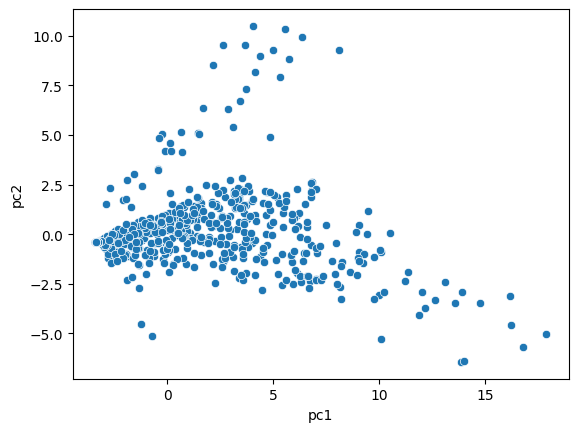

In [ ]:
sns.scatterplot(data=pca_player_data, x='pc1', y='pc2')
plt.show()

###K-Means Clustering

In [ ]:
from sklearn.cluster import KMeans

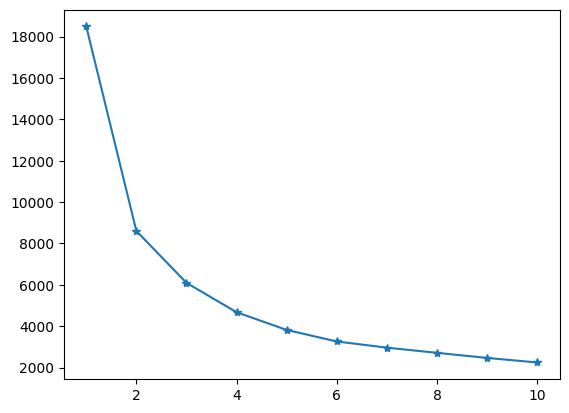

In [ ]:
# using elbow analysis to try and get a good value for k
k_values = np.arange(1, 11)
inertias = []

for k in k_values:
  kmeans_model = KMeans(n_clusters=k, random_state=1)
  kmeans_labels = kmeans_model.fit(pca_player_data)
  inertias.append(kmeans_labels.inertia_)

plt.plot(k_values, inertias, '*-')

From the above plot, we can say that k=4 should give decent results.

In [ ]:
kmeans_model = KMeans(n_clusters=4, random_state=1)
kmeans_model.fit(pca_player_data)
kmeans_labels = kmeans_model.predict(pca_player_data)
kmeans_labels

array([0, 0, 0, 0, 2, 1, 1, 2, 2, 0, 1, 2, 1, 0, 0, 0, 0, 1, 2, 0, 0, 2,
       1, 1, 0, 2, 3, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 2, 0, 0,
       0, 0, 2, 2, 1, 0, 0, 0, 2, 2, 3, 1, 0, 0, 0, 0, 0, 0, 2, 0, 1, 0,
       2, 1, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0,
       2, 0, 2, 0, 0, 0, 0, 3, 2, 0, 0, 0, 1, 2, 2, 1, 2, 0, 0, 2, 2, 0,
       0, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0,
       3, 0, 0, 0, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 0, 2, 0, 1, 0, 2, 2, 2,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 2, 0, 2, 2, 2, 1,
       1, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 3, 0, 2, 2, 3, 0, 2, 0, 2, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2,
       0, 0, 2, 0, 2, 0, 3, 2, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 2, 2, 2,
       3, 0, 0, 2, 0, 2, 0, 0, 0, 0, 2, 0, 2, 3, 0, 0, 0, 0, 0, 0, 2, 0,
       2, 0, 0, 2, 2, 2, 0, 1, 2, 0, 0, 2, 2, 1, 0, 0, 0, 0, 1, 2, 0, 1,
       0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0,

In [ ]:
kmeans_player_data = player_data.copy()
kmeans_player_data['kmeans_label'] = kmeans_labels

In [ ]:
kmeans_player_data.head()

,first_name,second_name,team_name,position,chance_of_playing_this_round,chance_of_playing_next_round,ep_this,ep_next,form,now_cost,points_per_game,total_points,minutes,goals_scored,assists,clean_sheets,goals_conceded,saves,bonus,bps,influence,creativity,threat,starts,expected_goals,expected_assists,expected_goal_involvements,expected_goals_conceded,expected_goals_per_90,saves_per_90,expected_assists_per_90,kmeans_label
0,Folarin,Balogun,Arsenal,Forward,0.0,0.0,0.0,0.0,0.0,44,0.0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0
1,Cédric,Alves Soares,Arsenal,Defender,0.0,0.0,0.5,1.0,0.0,38,1.0,3,59,0,0,0,0,0,0,15,2.0,4.3,0.0,0,0.00,0.02,0.02,0.39,0.00,0.0,0.03,0
2,Mohamed,Elneny,Arsenal,Midfielder,100.0,100.0,0.5,1.0,0.0,44,2.0,6,25,0,1,0,0,0,0,16,4.0,2.1,10.0,0,0.08,0.01,0.09,0.13,0.29,0.0,0.04,0
3,Fábio,Ferreira Vieira,Arsenal,Midfielder,100.0,100.0,0.8,1.3,0.3,54,2.2,24,290,1,3,1,2,0,0,67,82.8,88.8,85.0,2,1.25,0.64,1.89,1.83,0.39,0.0,0.20,0
4,Gabriel,dos Santos Magalhães,Arsenal,Defender,100.0,100.0,4.7,5.2,4.2,54,4.1,134,2804,3,1,14,25,0,6,612,640.8,116.9,361.0,31,4.08,0.61,4.69,24.71,0.13,0.0,0.02,2


<Axes: xlabel='pc1', ylabel='pc2'>

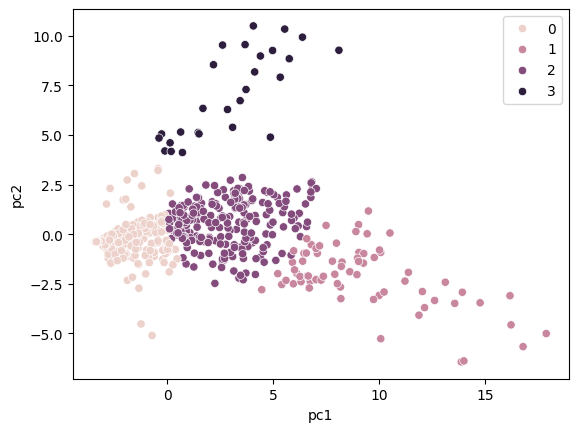

In [ ]:
sns.scatterplot(data=pca_player_data, x='pc1', y='pc2', hue=kmeans_labels)

In [ ]:
kmeans_profile = kmeans_player_data.groupby(['kmeans_label'])[numerical_cols].mean()
kmeans_profile['Count'] = kmeans_player_data.groupby('kmeans_label')['ep_this'].count()

In [ ]:
kmeans_profile.style.highlight_max(color='lightgreen').highlight_min(color='orange')

,chance_of_playing_this_round,chance_of_playing_next_round,ep_this,ep_next,form,now_cost,points_per_game,total_points,minutes,goals_scored,assists,clean_sheets,goals_conceded,saves,bonus,bps,influence,creativity,threat,starts,expected_goals,expected_assists,expected_goal_involvements,expected_goals_conceded,expected_goals_per_90,saves_per_90,expected_assists_per_90,Count
kmeans_label,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,16.853933,17.883895,0.120599,0.123783,0.133333,44.754682,0.626217,5.788390,153.215356,0.121723,0.134831,0.256554,3.316479,0.243446,0.204120,25.200375,29.843071,18.934082,18.411985,1.550562,0.181142,0.103390,0.284438,2.998427,0.064888,0.057603,0.031517,534
1,92.708333,92.708333,4.463889,4.047222,3.954167,66.361111,4.309722,127.458333,2208.083333,8.277778,6.583333,7.236111,33.819444,0.000000,13.666667,464.444444,630.708333,643.579167,657.083333,25.319444,7.622083,4.271806,11.892639,33.938611,0.322083,0.000000,0.177639,72
2,77.323009,79.977876,1.916814,1.713717,1.855310,48.588496,2.541150,62.225664,1703.606195,1.862832,1.867257,4.168142,31.747788,0.000000,4.154867,299.150442,371.561947,237.187168,203.579646,19.190265,1.934248,1.418274,3.352035,30.055133,0.119779,0.000000,0.082566,226
3,65.740741,65.740741,2.407407,2.151852,2.277778,46.740741,3.174074,77.740741,2139.555556,0.000000,0.074074,4.888889,38.851852,78.518519,7.148148,443.185185,623.481481,7.118519,0.148148,23.925926,0.000741,0.033704,0.034444,37.350370,0.000000,3.411852,0.000370,27


###K-Medoids Clustering

In [ ]:
!pip install scikit-learn-extra

In [ ]:
from sklearn_extra.cluster import KMedoids

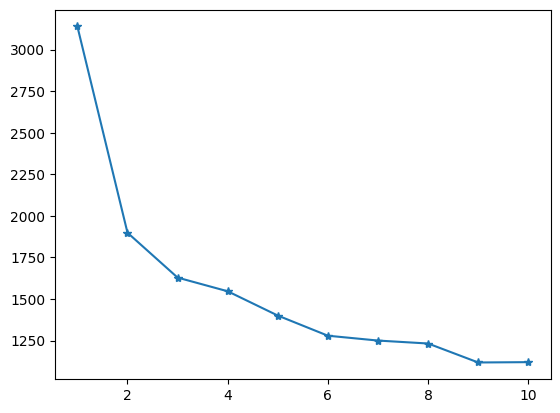

In [ ]:
# using elbow analysis to try and get a good value for k
k_values = np.arange(1, 11)
inertias = []

for k in k_values:
  kmedoids_model = KMedoids(n_clusters=k, random_state=1)
  kmedoids_labels = kmedoids_model.fit(pca_player_data)
  inertias.append(kmedoids_labels.inertia_)

plt.plot(k_values, inertias, '*-')

From the above elbow plot, it looks like k=5 would be a better value for KMedoids clustering.

In [ ]:
kmedoids_model = KMedoids(n_clusters=5, random_state=1)
kmedoids_model.fit(pca_player_data)
kmedoids_labels = kmedoids_model.predict(pca_player_data)
kmedoids_labels

array([3, 3, 2, 2, 0, 0, 0, 4, 4, 3, 0, 4, 0, 2, 3, 1, 3, 0, 0, 2, 3, 2,
       0, 0, 3, 0, 4, 0, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 4, 0, 3, 4, 3, 3,
       3, 1, 4, 0, 0, 2, 3, 2, 4, 4, 4, 0, 3, 2, 3, 1, 3, 3, 4, 3, 0, 3,
       4, 0, 3, 3, 1, 3, 2, 3, 3, 3, 3, 4, 3, 3, 3, 4, 1, 0, 4, 3, 3, 2,
       4, 3, 0, 3, 3, 1, 1, 4, 4, 3, 2, 1, 0, 0, 4, 0, 4, 3, 2, 4, 4, 3,
       3, 4, 4, 3, 1, 3, 3, 2, 3, 3, 3, 4, 3, 2, 3, 3, 3, 4, 3, 2, 1, 3,
       0, 3, 1, 1, 4, 0, 4, 0, 1, 4, 4, 4, 4, 2, 2, 4, 3, 0, 2, 4, 4, 0,
       3, 3, 2, 2, 3, 3, 3, 3, 3, 3, 0, 3, 3, 4, 3, 1, 0, 2, 4, 4, 4, 0,
       0, 3, 3, 2, 1, 1, 3, 1, 4, 2, 3, 3, 1, 3, 4, 4, 4, 2, 4, 3, 2, 1,
       2, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 2, 1, 4, 3, 2, 3, 4,
       3, 2, 4, 3, 4, 3, 4, 4, 3, 3, 1, 1, 4, 3, 3, 3, 4, 3, 3, 4, 4, 4,
       4, 1, 1, 4, 3, 4, 2, 1, 2, 1, 4, 2, 4, 4, 3, 3, 3, 3, 3, 3, 4, 2,
       2, 1, 1, 4, 4, 4, 3, 0, 4, 1, 3, 0, 0, 0, 1, 3, 3, 3, 0, 4, 3, 0,
       3, 1, 4, 3, 3, 3, 3, 3, 1, 3, 2, 4, 2, 3, 3,

In [ ]:
kmedoids_player_data = player_data.copy()
kmedoids_player_data['kmedoids_label'] = kmedoids_labels

In [ ]:
kmedoids_player_data.head()

,first_name,second_name,team_name,position,chance_of_playing_this_round,chance_of_playing_next_round,ep_this,ep_next,form,now_cost,points_per_game,total_points,minutes,goals_scored,assists,clean_sheets,goals_conceded,saves,bonus,bps,influence,creativity,threat,starts,expected_goals,expected_assists,expected_goal_involvements,expected_goals_conceded,expected_goals_per_90,saves_per_90,expected_assists_per_90,kmedoids_label
0,Folarin,Balogun,Arsenal,Forward,0.0,0.0,0.0,0.0,0.0,44,0.0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0,0.00,0.00,0.00,0.00,0.00,0.0,0.00,3
1,Cédric,Alves Soares,Arsenal,Defender,0.0,0.0,0.5,1.0,0.0,38,1.0,3,59,0,0,0,0,0,0,15,2.0,4.3,0.0,0,0.00,0.02,0.02,0.39,0.00,0.0,0.03,3
2,Mohamed,Elneny,Arsenal,Midfielder,100.0,100.0,0.5,1.0,0.0,44,2.0,6,25,0,1,0,0,0,0,16,4.0,2.1,10.0,0,0.08,0.01,0.09,0.13,0.29,0.0,0.04,2
3,Fábio,Ferreira Vieira,Arsenal,Midfielder,100.0,100.0,0.8,1.3,0.3,54,2.2,24,290,1,3,1,2,0,0,67,82.8,88.8,85.0,2,1.25,0.64,1.89,1.83,0.39,0.0,0.20,2
4,Gabriel,dos Santos Magalhães,Arsenal,Defender,100.0,100.0,4.7,5.2,4.2,54,4.1,134,2804,3,1,14,25,0,6,612,640.8,116.9,361.0,31,4.08,0.61,4.69,24.71,0.13,0.0,0.02,0


<Axes: xlabel='pc1', ylabel='pc2'>

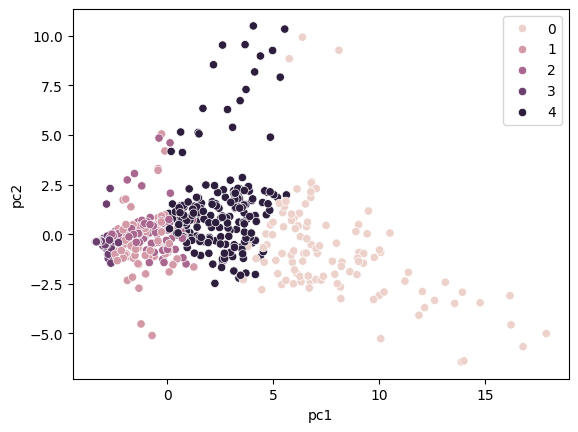

In [ ]:
sns.scatterplot(data=pca_player_data, x='pc1', y='pc2', hue=kmedoids_labels)

In [ ]:
kmedoids_profile = kmedoids_player_data.groupby('kmedoids_label')[numerical_cols].mean()
kmedoids_profile['Count'] = kmedoids_player_data.groupby('kmedoids_label')['ep_this'].count()

In [ ]:
kmedoids_profile.style.highlight_max(color='lightgreen').highlight_min(color='orange')

,chance_of_playing_this_round,chance_of_playing_next_round,ep_this,ep_next,form,now_cost,points_per_game,total_points,minutes,goals_scored,assists,clean_sheets,goals_conceded,saves,bonus,bps,influence,creativity,threat,starts,expected_goals,expected_assists,expected_goal_involvements,expected_goals_conceded,expected_goals_per_90,saves_per_90,expected_assists_per_90,Count
kmedoids_label,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,93.750000,92.857143,4.207143,3.809821,3.775000,61.187500,3.920536,116.517857,2255.937500,6.375000,5.187500,7.339286,35.517857,3.044643,11.705357,457.714286,604.000000,532.512500,526.776786,25.839286,5.881339,3.511696,9.391964,35.555893,0.253214,0.088125,0.145982,112
1,6.111111,11.388889,0.055556,0.132222,0.160000,47.033333,1.832222,21.711111,607.455556,0.577778,0.555556,0.955556,12.511111,2.000000,1.055556,100.377778,126.217778,72.257778,72.322222,6.488889,0.765111,0.413889,1.178778,11.613111,0.224000,0.186667,0.111556,90
2,91.826923,92.307692,0.815385,0.802885,0.823077,44.663462,1.386538,15.711538,398.548077,0.240385,0.355769,0.894231,8.346154,1.028846,0.375000,67.490385,76.476923,48.364423,45.519231,3.923077,0.435673,0.262596,0.697981,7.427212,0.107885,0.208654,0.056154,104
3,1.385042,1.454294,0.037396,0.013296,0.017175,44.271468,0.193906,0.542936,12.825485,0.000000,0.000000,0.002770,0.382271,0.024931,0.002770,2.027701,1.976731,1.057895,1.332410,0.099723,0.009169,0.004100,0.013269,0.314681,0.017258,0.018006,0.006205,361
4,72.005208,75.651042,1.611979,1.437500,1.602604,47.953125,2.533854,60.395833,1719.619792,1.515625,1.572917,3.802083,32.916667,8.401042,4.057292,304.281250,387.913542,201.503125,168.916667,19.333333,1.596302,1.171198,2.767083,30.896823,0.098646,0.354219,0.071979,192


###Agglomerative(Heirarchical) Clustering

In [ ]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

In [ ]:
affinities = ['euclidean', 'manhattan', 'chebyshev', 'minkowski']
linkages = ['ward', 'complete', 'average', 'single']

In [ ]:
ideal_i = ''
ideal_j = ''

max_score = -float('inf')

for i in affinities:
  for j in linkages:
    if j=='ward':
      i = 'euclidean'
    print('*'*50)
    agg_model = AgglomerativeClustering(n_clusters=4, affinity=i, linkage=j)
    agg_model.fit(pca_player_data)
    score = silhouette_score(pca_player_data, agg_model.labels_)
    print('score: ', score)
    print('affinity: ', i)
    print('linkage: ', j)
    print('*'*50)
    if score > max_score:
      max_score = score
      ideal_i = i
      ideal_j = j

print('IDEAL VALUES:')
print('score: ', max_score)
print('affinity: ', ideal_i)
print('linkage: ', ideal_j)

**************************************************
score:  0.4982624055774759
affinity:  euclidean
linkage:  ward
**************************************************
**************************************************
score:  0.5219954573303913
affinity:  euclidean
linkage:  complete
**************************************************
**************************************************
score:  0.5478194866328056
affinity:  euclidean
linkage:  average
**************************************************
**************************************************
score:  0.2812547536045479
affinity:  euclidean
linkage:  single
**************************************************
**************************************************
score:  0.4982624055774759
affinity:  euclidean
linkage:  ward
**************************************************
**************************************************
score:  0.5219954573303913
affinity:  euclidean
linkage:  complete
************************************************

In [ ]:
agg_model = AgglomerativeClustering(n_clusters=4, affinity=ideal_i, linkage=ideal_j)
agg_model.fit(pca_player_data)

AgglomerativeClustering(affinity='euclidean', linkage='average', n_clusters=4)

In [ ]:
agg_labels = agg_model.labels_

In [ ]:
agg_player_data = player_data.copy()
agg_player_data['agg_label'] = agg_labels

In [ ]:
agg_player_data.head()

,first_name,second_name,team_name,position,chance_of_playing_this_round,chance_of_playing_next_round,ep_this,ep_next,form,now_cost,points_per_game,total_points,minutes,goals_scored,assists,clean_sheets,goals_conceded,saves,bonus,bps,influence,creativity,threat,starts,expected_goals,expected_assists,expected_goal_involvements,expected_goals_conceded,expected_goals_per_90,saves_per_90,expected_assists_per_90,agg_label
0,Folarin,Balogun,Arsenal,Forward,0.0,0.0,0.0,0.0,0.0,44,0.0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0,0.00,0.00,0.00,0.00,0.00,0.0,0.00,1
1,Cédric,Alves Soares,Arsenal,Defender,0.0,0.0,0.5,1.0,0.0,38,1.0,3,59,0,0,0,0,0,0,15,2.0,4.3,0.0,0,0.00,0.02,0.02,0.39,0.00,0.0,0.03,1
2,Mohamed,Elneny,Arsenal,Midfielder,100.0,100.0,0.5,1.0,0.0,44,2.0,6,25,0,1,0,0,0,0,16,4.0,2.1,10.0,0,0.08,0.01,0.09,0.13,0.29,0.0,0.04,1
3,Fábio,Ferreira Vieira,Arsenal,Midfielder,100.0,100.0,0.8,1.3,0.3,54,2.2,24,290,1,3,1,2,0,0,67,82.8,88.8,85.0,2,1.25,0.64,1.89,1.83,0.39,0.0,0.20,1
4,Gabriel,dos Santos Magalhães,Arsenal,Defender,100.0,100.0,4.7,5.2,4.2,54,4.1,134,2804,3,1,14,25,0,6,612,640.8,116.9,361.0,31,4.08,0.61,4.69,24.71,0.13,0.0,0.02,3


<Axes: xlabel='pc1', ylabel='pc2'>

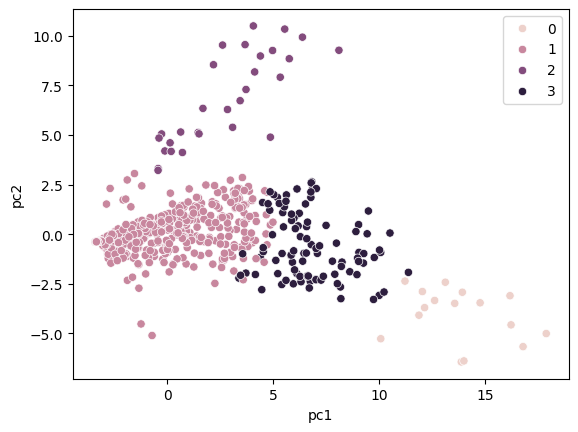

In [ ]:
sns.scatterplot(data=pca_player_data, x='pc1', y='pc2', hue=agg_labels)

In [ ]:
agg_profile = agg_player_data.groupby('agg_label')[numerical_cols].mean()
agg_profile['Count'] = agg_player_data.groupby('agg_label')['ep_this'].count()

In [ ]:
agg_profile.style.highlight_max(color='lightgreen').highlight_min(color='orange')

,chance_of_playing_this_round,chance_of_playing_next_round,ep_this,ep_next,form,now_cost,points_per_game,total_points,minutes,goals_scored,assists,clean_sheets,goals_conceded,saves,bonus,bps,influence,creativity,threat,starts,expected_goals,expected_assists,expected_goal_involvements,expected_goals_conceded,expected_goals_per_90,saves_per_90,expected_assists_per_90,Count
agg_label,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,95.312500,96.875000,6.937500,6.087500,5.850000,86.312500,5.668750,177.625000,2553.187500,14.812500,9.062500,9.375000,35.375000,0.000000,21.312500,609.625000,872.712500,771.206250,1036.437500,29.187500,13.608750,5.525625,19.132500,36.621875,0.498125,0.000000,0.192500,16
1,32.132867,33.776224,0.528531,0.480140,0.519301,45.562238,1.073566,18.253147,505.598601,0.506294,0.497902,1.076923,10.011189,0.102098,1.009790,86.369231,105.818462,66.674406,59.195804,5.542657,0.568336,0.379119,0.947287,9.243329,0.078657,0.035986,0.043734,715
2,62.931034,62.931034,2.303448,2.100000,2.200000,46.379310,3.148276,74.517241,2063.379310,0.000000,0.068966,4.655172,37.310345,75.068966,6.793103,425.206897,597.262069,6.972414,0.137931,23.068966,0.000690,0.033793,0.034483,35.655172,0.000000,3.350000,0.000345,29
3,86.868687,86.363636,3.316162,3.043434,3.111111,56.737374,3.586869,104.808081,2236.262626,4.878788,4.717172,6.838384,36.606061,0.000000,9.747475,430.626263,557.676768,505.366667,446.898990,25.606061,4.631919,3.270303,7.901212,36.532626,0.209091,0.000000,0.140707,99


###Gaussian Mixture Model

In [ ]:
#Gaussian Mixture Model assumes that the data points form many Gaussian(normal) distributions.
#It is an example of soft clustering, i.e., each data point is given a probability to belong to each cluster.

from sklearn.mixture import GaussianMixture

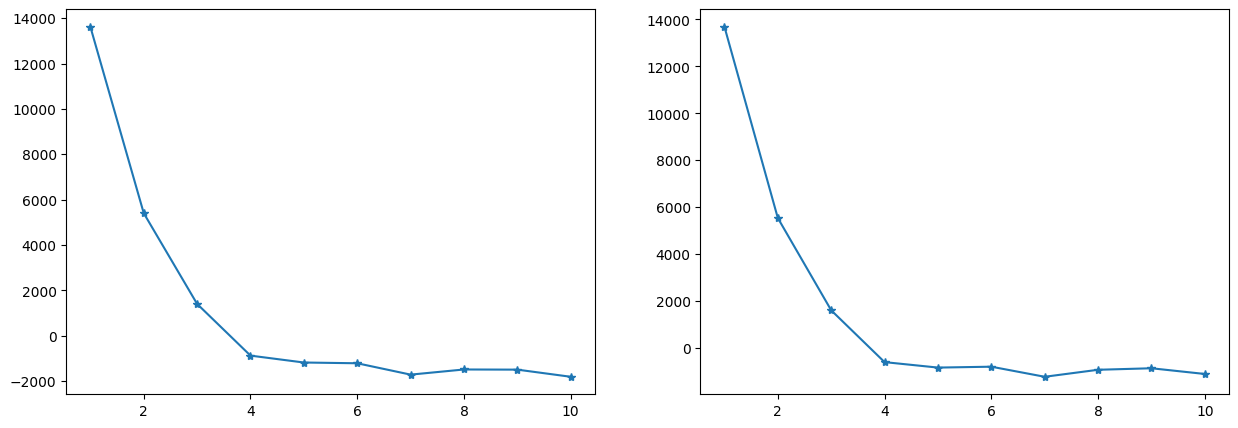

In [ ]:
#using bic/aic scores to find the ideal number of components

bic_scores = []
aic_scores = []
k_values = np.arange(1,11)

for k in k_values:
  gmm_model = GaussianMixture(n_components=k, random_state=1)
  gmm_model.fit(pca_player_data)
  bic_scores.append(gmm_model.bic(pca_player_data))
  aic_scores.append(gmm_model.aic(pca_player_data))

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(k_values, aic_scores, '*-')
plt.subplot(1,2,2)
plt.plot(k_values, bic_scores, '*-')

In [ ]:
gmm_model = GaussianMixture(n_components=4, random_state=1)

In [ ]:
gmm_model.fit(pca_player_data)
gmm_labels = gmm_model.predict(pca_player_data)

In [ ]:
gmm_labels

array([0, 3, 3, 2, 2, 2, 2, 3, 2, 0, 2, 2, 2, 3, 0, 1, 0, 2, 2, 2, 0, 2,
       2, 2, 0, 2, 1, 2, 3, 3, 0, 0, 0, 0, 0, 3, 0, 0, 3, 2, 0, 2, 3, 3,
       0, 3, 2, 2, 2, 2, 0, 3, 3, 2, 1, 2, 2, 1, 3, 2, 0, 0, 2, 3, 2, 0,
       2, 2, 3, 0, 3, 0, 3, 0, 0, 0, 3, 2, 0, 0, 3, 2, 2, 2, 2, 0, 0, 3,
       2, 0, 2, 0, 0, 3, 2, 1, 2, 0, 3, 3, 2, 2, 2, 2, 2, 3, 1, 2, 3, 1,
       0, 3, 3, 3, 2, 3, 0, 2, 3, 0, 0, 2, 0, 3, 0, 0, 0, 2, 0, 2, 2, 0,
       1, 0, 3, 3, 2, 2, 2, 2, 3, 2, 3, 2, 2, 2, 1, 2, 0, 2, 3, 2, 2, 2,
       3, 0, 3, 3, 0, 3, 0, 0, 0, 0, 2, 0, 0, 2, 0, 3, 2, 3, 2, 2, 2, 2,
       2, 0, 0, 2, 3, 2, 0, 2, 2, 3, 0, 0, 1, 0, 2, 3, 1, 3, 2, 0, 3, 3,
       3, 2, 3, 3, 0, 0, 0, 0, 0, 3, 0, 3, 0, 3, 0, 3, 3, 2, 0, 3, 0, 2,
       0, 2, 2, 0, 2, 0, 1, 2, 3, 0, 3, 2, 2, 0, 0, 0, 3, 0, 3, 2, 2, 2,
       1, 3, 2, 2, 0, 2, 3, 3, 3, 3, 2, 3, 2, 1, 0, 3, 0, 0, 0, 0, 3, 3,
       2, 2, 3, 3, 2, 2, 0, 2, 2, 2, 0, 2, 2, 2, 3, 0, 0, 0, 2, 2, 0, 2,
       0, 3, 2, 3, 3, 0, 3, 0, 2, 0, 3, 1, 2, 0, 3,

In [ ]:
gmm_player_data = player_data.copy()
gmm_player_data['gmm_label'] = gmm_labels

In [ ]:
gmm_player_data.head()

,first_name,second_name,team_name,position,chance_of_playing_this_round,chance_of_playing_next_round,ep_this,ep_next,form,now_cost,points_per_game,total_points,minutes,goals_scored,assists,clean_sheets,goals_conceded,saves,bonus,bps,influence,creativity,threat,starts,expected_goals,expected_assists,expected_goal_involvements,expected_goals_conceded,expected_goals_per_90,saves_per_90,expected_assists_per_90,gmm_label
0,Folarin,Balogun,Arsenal,Forward,0.0,0.0,0.0,0.0,0.0,44,0.0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0
1,Cédric,Alves Soares,Arsenal,Defender,0.0,0.0,0.5,1.0,0.0,38,1.0,3,59,0,0,0,0,0,0,15,2.0,4.3,0.0,0,0.00,0.02,0.02,0.39,0.00,0.0,0.03,3
2,Mohamed,Elneny,Arsenal,Midfielder,100.0,100.0,0.5,1.0,0.0,44,2.0,6,25,0,1,0,0,0,0,16,4.0,2.1,10.0,0,0.08,0.01,0.09,0.13,0.29,0.0,0.04,3
3,Fábio,Ferreira Vieira,Arsenal,Midfielder,100.0,100.0,0.8,1.3,0.3,54,2.2,24,290,1,3,1,2,0,0,67,82.8,88.8,85.0,2,1.25,0.64,1.89,1.83,0.39,0.0,0.20,2
4,Gabriel,dos Santos Magalhães,Arsenal,Defender,100.0,100.0,4.7,5.2,4.2,54,4.1,134,2804,3,1,14,25,0,6,612,640.8,116.9,361.0,31,4.08,0.61,4.69,24.71,0.13,0.0,0.02,2


<Axes: xlabel='pc1', ylabel='pc2'>

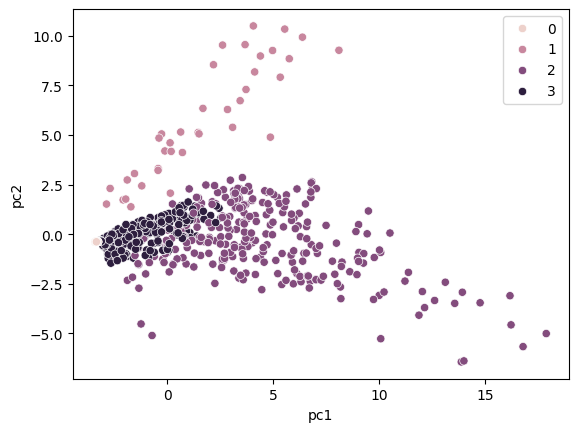

In [ ]:
sns.scatterplot(data=pca_player_data, x='pc1', y='pc2', hue=gmm_labels)

In [ ]:
gmm_profile = gmm_player_data.groupby('gmm_label')[numerical_cols].mean()
gmm_profile['Count'] = gmm_player_data.groupby('gmm_label')['ep_this'].count()

In [ ]:
gmm_profile.style.highlight_max(color='lightgreen').highlight_min(color='orange')

,chance_of_playing_this_round,chance_of_playing_next_round,ep_this,ep_next,form,now_cost,points_per_game,total_points,minutes,goals_scored,assists,clean_sheets,goals_conceded,saves,bonus,bps,influence,creativity,threat,starts,expected_goals,expected_assists,expected_goal_involvements,expected_goals_conceded,expected_goals_per_90,saves_per_90,expected_assists_per_90,Count
gmm_label,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.000000,0.000000,0.000712,-0.014591,0.000000,44.110320,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,281
1,56.578947,56.578947,1.921053,1.726316,1.789474,45.026316,3.068421,59.315789,1643.447368,0.000000,0.052632,3.763158,29.710526,59.210526,5.315789,337.631579,471.668421,5.584211,0.105263,18.263158,0.000526,0.026579,0.027105,28.200263,0.000000,3.233684,0.000526,38
2,78.057554,79.766187,2.654676,2.392446,2.457194,53.600719,3.014748,78.435252,1756.859712,3.633094,3.158273,4.834532,30.744604,0.000000,6.687050,331.438849,426.777698,342.530576,328.316547,19.888489,3.497518,2.167302,5.664137,29.463633,0.222950,0.000000,0.128345,278
3,42.270992,44.847328,0.277863,0.291221,0.326718,45.469466,1.335878,16.683206,506.580153,0.274809,0.343511,0.935115,10.511450,0.000000,0.625954,82.064885,97.658779,56.524046,45.339695,5.385496,0.421183,0.308015,0.728969,9.859389,0.087519,0.000000,0.048053,262


###DBSCAN Clustering

In [ ]:
from sklearn.cluster import DBSCAN

In [ ]:
#DBSCAN is a density-based clustering. We do not have to mention the number of clusters beforehand.
#DBSCAN clustering has two important parameters- epsilon and minpts.
#Epsilon: the radius within which a specified number of points must exist for a point to be considered a core point.
#MinPts: the minimum number of points that must exist within epsilon radius of a point for that point to be considered a core point.
#Core points which are reachable from each other form a cluster.
#Points which are not core points but within epsilon radius of a cluster form border points.
#Points which are neither a core point nor a border point form a noise point(outlier).

#We will compare the silhouette scores of DBSCAN clustering with different combinations of epsilon and min_samples. We also need to make sure that there are at least 3 clusters to get some meaningful clustering.


from sklearn.metrics import silhouette_score

In [ ]:
epsilon_ = [0.1, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0]
min_samples_ = [3, 5, 8, 10, 15, 20, 25]

In [ ]:
max_score = -float('inf')

for i in epsilon_:
  for j in min_samples_:
    dbs_model = DBSCAN(eps=i, min_samples=j)
    dbs_model.fit(pca_player_data)
    dbs_labels = dbs_model.labels_
    score = silhouette_score(pca_player_data, dbs_labels)
    print('*'*50)
    print('Score: ', score)
    print('eps: ', i)
    print('min_samples: ', j)
    print('Number of clusters: ', len(np.unique(dbs_labels))-1)
    print('*'*50)
    if (score > max_score) and (len(np.unique(dbs_labels))-1 > 2):
      max_score = score
      ideal_eps = i
      ideal_min_samples = j
      ideal_dbs_labels = dbs_labels

print('IDEAL VALUES:')
print('Score: ', max_score)
print('eps: ', ideal_eps)
print('min_samples: ', ideal_min_samples)
print('Number of clusters: ', len(np.unique(ideal_dbs_labels))-1)

**************************************************
Score:  0.13304426273754522
eps:  0.1
min_samples:  3
Number of clusters:  13
**************************************************
**************************************************
Score:  0.10854852247562839
eps:  0.1
min_samples:  5
Number of clusters:  6
**************************************************
**************************************************
Score:  0.10822825629645216
eps:  0.1
min_samples:  8
Number of clusters:  3
**************************************************
**************************************************
Score:  0.10822825629645216
eps:  0.1
min_samples:  10
Number of clusters:  3
**************************************************
**************************************************
Score:  0.10822825629645216
eps:  0.1
min_samples:  15
Number of clusters:  3
**************************************************
**************************************************
Score:  0.1497785986647474
eps:  0.1
min_samples:  

In [ ]:
dbs_model = DBSCAN(eps=ideal_eps, min_samples=ideal_min_samples)
dbs_model.fit(pca_player_data)
dbs_labels = dbs_model.labels_

In [ ]:
dbs_labels

array([ 0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,
       -1,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,
        0,  2,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0

In [ ]:
dbs_player_data = player_data.copy()
dbs_player_data['dbs_label'] = dbs_labels

In [ ]:
dbs_player_data.head()

,first_name,second_name,team_name,position,chance_of_playing_this_round,chance_of_playing_next_round,ep_this,ep_next,form,now_cost,points_per_game,total_points,minutes,goals_scored,assists,clean_sheets,goals_conceded,saves,bonus,bps,influence,creativity,threat,starts,expected_goals,expected_assists,expected_goal_involvements,expected_goals_conceded,expected_goals_per_90,saves_per_90,expected_assists_per_90,dbs_label
0,Folarin,Balogun,Arsenal,Forward,0.0,0.0,0.0,0.0,0.0,44,0.0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0
1,Cédric,Alves Soares,Arsenal,Defender,0.0,0.0,0.5,1.0,0.0,38,1.0,3,59,0,0,0,0,0,0,15,2.0,4.3,0.0,0,0.00,0.02,0.02,0.39,0.00,0.0,0.03,0
2,Mohamed,Elneny,Arsenal,Midfielder,100.0,100.0,0.5,1.0,0.0,44,2.0,6,25,0,1,0,0,0,0,16,4.0,2.1,10.0,0,0.08,0.01,0.09,0.13,0.29,0.0,0.04,0
3,Fábio,Ferreira Vieira,Arsenal,Midfielder,100.0,100.0,0.8,1.3,0.3,54,2.2,24,290,1,3,1,2,0,0,67,82.8,88.8,85.0,2,1.25,0.64,1.89,1.83,0.39,0.0,0.20,0
4,Gabriel,dos Santos Magalhães,Arsenal,Defender,100.0,100.0,4.7,5.2,4.2,54,4.1,134,2804,3,1,14,25,0,6,612,640.8,116.9,361.0,31,4.08,0.61,4.69,24.71,0.13,0.0,0.02,0


<Axes: xlabel='pc1', ylabel='pc2'>

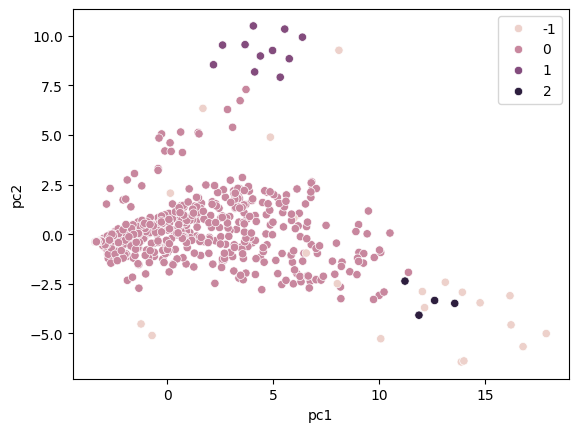

In [ ]:
sns.scatterplot(data=pca_player_data, x='pc1', y='pc2', hue=dbs_labels)

In [ ]:
dbs_profile = dbs_player_data.groupby('dbs_label')[numerical_cols].mean()
dbs_profile['Count'] = dbs_player_data.groupby('dbs_label')['ep_this'].count()

In [ ]:
dbs_profile.style.highlight_max(color='lightgreen').highlight_min(color='orange')

,chance_of_playing_this_round,chance_of_playing_next_round,ep_this,ep_next,form,now_cost,points_per_game,total_points,minutes,goals_scored,assists,clean_sheets,goals_conceded,saves,bonus,bps,influence,creativity,threat,starts,expected_goals,expected_assists,expected_goal_involvements,expected_goals_conceded,expected_goals_per_90,saves_per_90,expected_assists_per_90,Count
dbs_label,,,,,,,,,,,,,,,,,,,,,,,,,,,,
-1,85.714286,85.714286,6.171429,5.728571,5.452381,74.571429,5.023810,130.714286,1967.380952,8.809524,6.428571,7.714286,25.380952,9.714286,16.190476,485.761905,660.666667,557.790476,620.666667,22.380952,8.159048,3.950000,12.107619,26.861429,0.584286,0.651429,0.221905,21
0,38.912515,40.309842,0.865857,0.788700,0.832199,46.804374,1.390158,29.048603,728.765492,1.018226,0.976914,1.797084,13.479951,0.964763,2.066829,130.534629,164.107169,116.343499,104.374241,8.122722,1.045261,0.706124,1.751118,12.759356,0.086282,0.084192,0.052224,823
1,68.181818,65.909091,2.163636,1.727273,2.072727,47.545455,3.090909,99.272727,2848.636364,0.000000,0.181818,5.181818,56.545455,113.818182,9.909091,594.090909,901.272727,8.900000,0.000000,31.909091,0.000000,0.032727,0.032727,54.530000,0.000000,3.628182,0.000000,11
2,87.500000,93.750000,4.500000,3.625000,3.625000,77.750000,5.275000,171.500000,2789.500000,14.750000,7.250000,8.500000,45.250000,0.000000,18.750000,576.250000,826.500000,670.700000,1055.250000,32.000000,12.772500,4.942500,17.715000,45.197500,0.407500,0.000000,0.162500,4


###Choosing a Model

We have now used 5 different models to cluster our dataset. Let's take a look at compare the silhouette scores of all 5 models to choose the most apt model for our purpose.

In [ ]:
from sklearn.metrics import silhouette_score

**************************************************
KMeans : 
score:  0.5655521851055834
**************************************************
**************************************************
KMedoids : 
score:  0.4407172948390081
**************************************************
**************************************************
Agglomerative : 
score:  0.5478194866328056
**************************************************
**************************************************
Gaussian Mixture Model : 
score:  0.3009425543545284
**************************************************
**************************************************
DBSCAN : 
score:  0.5446375084957182
**************************************************
IDEAL MODEL: 
Model:  KMeans
Score:  0.5655521851055834


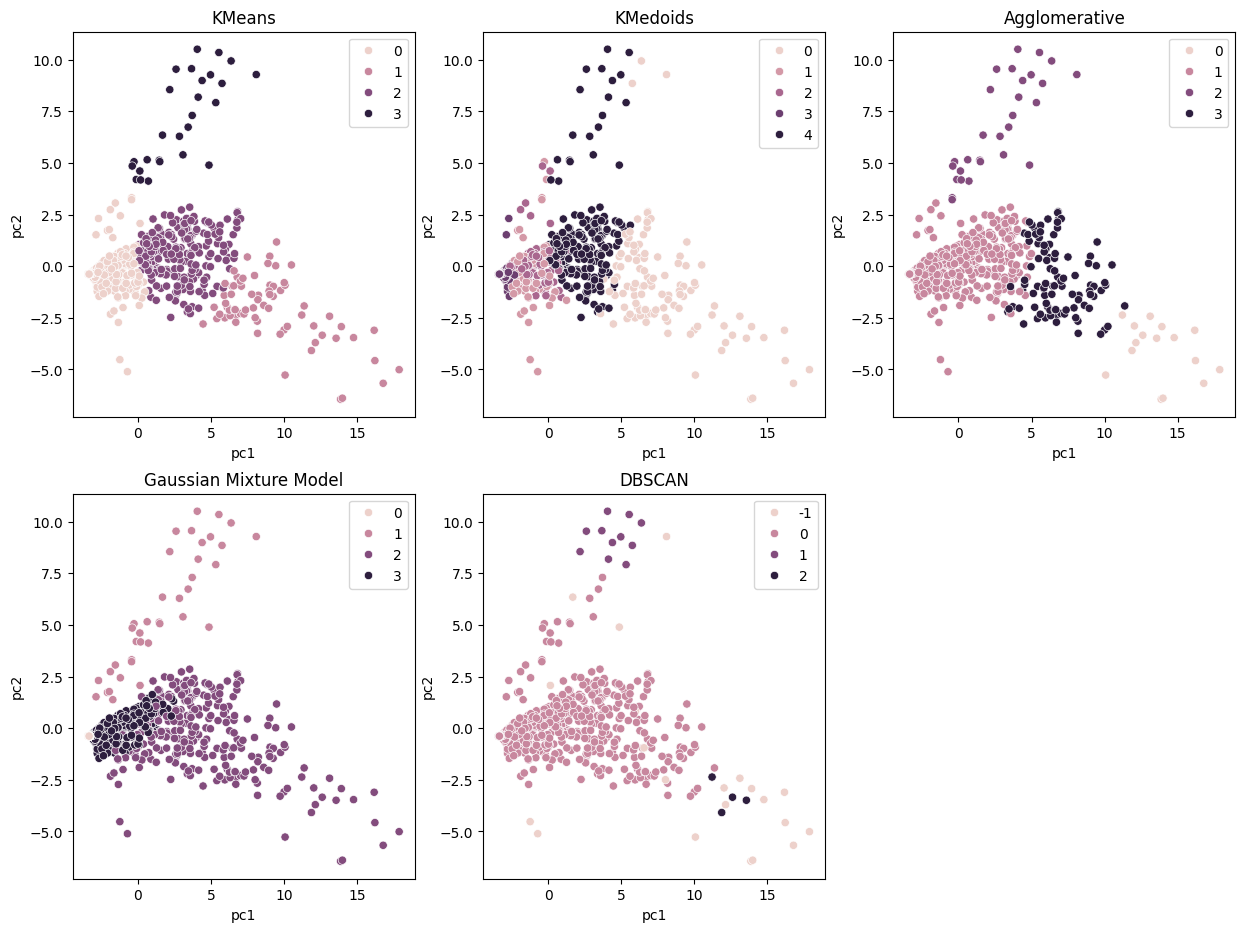

In [ ]:
labels = [kmeans_labels, kmedoids_labels, agg_labels, gmm_labels, dbs_labels]
models = ['KMeans', 'KMedoids', 'Agglomerative', 'Gaussian Mixture Model', 'DBSCAN']
profiles = [kmeans_profile, kmedoids_profile, agg_profile, gmm_profile, dbs_profile]
#labels2 = [kmeans_label, kmedoids_label, agg_label, gmm_label, dbs_label]

plt.figure(figsize=(15,11))
for i in range(5):
  plt.subplot(2,3,i+1)
  sns.scatterplot(data=pca_player_data, x='pc1', y='pc2', hue=labels[i])
  plt.title(models[i])

flag = True
max_score = -float('inf')

for i in range(5):
  l = labels[i]
  score = silhouette_score(pca_player_data, l)
  print('*'*50)
  print(models[i],': ')
  print('score: ', score)
  print('*'*50)

  # We are making sure that the clusters are balanced(no single cluster has majority of the datapoints), we check if there is more than 80 percent
  #of the total data in any one cluster. If so, we don't consider that cluster.
  for k in l:
    if profiles[i].iloc[k]['Count'] > (0.8*len(player_data)):
      flag = False
  if flag==True and score > max_score:
    ideal_model = models[i]
    ideal_labels = labels[i]
    max_score = score

print('IDEAL MODEL: ')
print('Model: ', ideal_model)
print('Score: ', max_score)

We can see that KMeans clustering has the highest silhouette score. Here, even though kmeans clustering assigns majority of the players to one cluster, these are players that we want to avoid while selecting a team, so it makes sense. There is no huge imbalance between the rest of the clusters.

So we'll go ahead with **Kmeans Clustering**

###Defining the clusters

Let's take a look at the profile of each label and the observations we made from it.

In [ ]:
kmeans_profile.style.highlight_max(color='lightgreen').highlight_min(color='orange')

,chance_of_playing_this_round,chance_of_playing_next_round,ep_this,ep_next,form,now_cost,points_per_game,total_points,minutes,goals_scored,assists,clean_sheets,goals_conceded,saves,bonus,bps,influence,creativity,threat,starts,expected_goals,expected_assists,expected_goal_involvements,expected_goals_conceded,expected_goals_per_90,saves_per_90,expected_assists_per_90,Count
kmeans_label,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,16.853933,17.883895,0.120599,0.123783,0.133333,44.754682,0.626217,5.788390,153.215356,0.121723,0.134831,0.256554,3.316479,0.243446,0.204120,25.200375,29.843071,18.934082,18.411985,1.550562,0.181142,0.103390,0.284438,2.998427,0.064888,0.057603,0.031517,534
1,92.708333,92.708333,4.463889,4.047222,3.954167,66.361111,4.309722,127.458333,2208.083333,8.277778,6.583333,7.236111,33.819444,0.000000,13.666667,464.444444,630.708333,643.579167,657.083333,25.319444,7.622083,4.271806,11.892639,33.938611,0.322083,0.000000,0.177639,72
2,77.323009,79.977876,1.916814,1.713717,1.855310,48.588496,2.541150,62.225664,1703.606195,1.862832,1.867257,4.168142,31.747788,0.000000,4.154867,299.150442,371.561947,237.187168,203.579646,19.190265,1.934248,1.418274,3.352035,30.055133,0.119779,0.000000,0.082566,226
3,65.740741,65.740741,2.407407,2.151852,2.277778,46.740741,3.174074,77.740741,2139.555556,0.000000,0.074074,4.888889,38.851852,78.518519,7.148148,443.185185,623.481481,7.118519,0.148148,23.925926,0.000741,0.033704,0.034444,37.350370,0.000000,3.411852,0.000370,27


In [ ]:
[gk_cluster, flop_cluster, defensive_cluster, offensive_cluster] = kmeans_profile.sort_values(by='goals_scored').index

In [ ]:
print('Flop cluster: ', flop_cluster)
print('Good GK cluster: ', gk_cluster)
print('Defensive cluster: ', defensive_cluster)
print('Offensive cluster: ', offensive_cluster)

Flop cluster:  0
Good GK cluster:  3
Defensive cluster:  2
Offensive cluster:  1


In [ ]:
#creating a new dataframe with the defined clusters

def to_cluster(label):
  if label==flop_cluster:
    return 'Flop'
  elif label==offensive_cluster:
    return 'Offensive'
  elif label==defensive_cluster:
    return 'Defensive'
  elif label==gk_cluster:
    return 'Good GK'

data = player_data.copy()
data['Cluster'] = kmeans_player_data['kmeans_label'].apply(to_cluster)
data = pd.concat([data[['first_name','second_name','team_name','position','Cluster']], data.drop(columns=['first_name','second_name','team_name','position','Cluster'])], axis=1)
data.head()

,first_name,second_name,team_name,position,Cluster,chance_of_playing_this_round,chance_of_playing_next_round,ep_this,ep_next,form,now_cost,points_per_game,total_points,minutes,goals_scored,assists,clean_sheets,goals_conceded,saves,bonus,bps,influence,creativity,threat,starts,expected_goals,expected_assists,expected_goal_involvements,expected_goals_conceded,expected_goals_per_90,saves_per_90,expected_assists_per_90
0,Folarin,Balogun,Arsenal,Forward,Flop,0.0,0.0,0.0,0.0,0.0,44,0.0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0,0.00,0.00,0.00,0.00,0.00,0.0,0.00
1,Cédric,Alves Soares,Arsenal,Defender,Flop,0.0,0.0,0.5,1.0,0.0,38,1.0,3,59,0,0,0,0,0,0,15,2.0,4.3,0.0,0,0.00,0.02,0.02,0.39,0.00,0.0,0.03
2,Mohamed,Elneny,Arsenal,Midfielder,Flop,100.0,100.0,0.5,1.0,0.0,44,2.0,6,25,0,1,0,0,0,0,16,4.0,2.1,10.0,0,0.08,0.01,0.09,0.13,0.29,0.0,0.04
3,Fábio,Ferreira Vieira,Arsenal,Midfielder,Flop,100.0,100.0,0.8,1.3,0.3,54,2.2,24,290,1,3,1,2,0,0,67,82.8,88.8,85.0,2,1.25,0.64,1.89,1.83,0.39,0.0,0.20
4,Gabriel,dos Santos Magalhães,Arsenal,Defender,Defensive,100.0,100.0,4.7,5.2,4.2,54,4.1,134,2804,3,1,14,25,0,6,612,640.8,116.9,361.0,31,4.08,0.61,4.69,24.71,0.13,0.0,0.02


In [ ]:
data[data['Cluster']=='Defensive']['position'].value_counts()

position
Defender      111
Midfielder     95
Forward        20
Name: count, dtype: int64

###Player selection

####Strategy for selecting players

* You want to choose your **midfielders and forwards from the offensive cluster**. If you could exceed the budget, choose from cluster 2.
* You want to choose your **defenders primarily from the offensive cluster, giving second priority to the defensive cluster**.
* You want to choose your **goalkeeper from the Good GK cluster**, probably after sorting the number of saves made in a game, because that feature has a good correlation with the points accumulated.
* You definitely want to **avoid the players in the Flop cluster**.
* You might want to **sort the players in ascending order of their cost** to identify cost-effective players.
* You want to try and keep the cost of players as low as possible.
* The starting XI, captain and vice-captain are selected based on the recent form.

Note: Run this notebook as close to the transfer deadline as possible to get the latest data.

In [ ]:
data.groupby('position')['now_cost'].mean()

position
Defender      43.505415
Forward       53.292035
Goalkeeper    41.969388
Midfielder    50.495957
Name: now_cost, dtype: float64

Your team needs
* 2 Goalkeepers
* 5 Defenders
* 5 Midfielders
* 3 Forwards

We are using an upper limit of $10 for every player to ensure that we select a cheap team and a minimum form of 3.0 to make sure that the players we select have been having a good run recently.

In [ ]:
def create_team(data, cost_limit, min_form):

  potential_fwd = data[(data['now_cost']<cost_limit) & (data['position']=='Forward') & (data['Cluster']=='Offensive') & (data['chance_of_playing_this_round']>=75) & (data['chance_of_playing_next_round']>=75) & (data['form']>=min_form)].sort_values(by=['form','points_per_game'], ascending=False)
  if len(potential_fwd)>=3:
    forwards = potential_fwd[:3]
  else:
    forwards = potential_fwd
    forwards = forwards._append(data[(data['now_cost']<cost_limit) & (data['position']=='Forward') & (data['Cluster']=='Defensive') & (data['chance_of_playing_this_round']>=75) & (data['chance_of_playing_next_round']>=75) & (data['form']>=min_form)].sort_values(by=['form','points_per_game'])[:3-len(potential_fwd)], ignore_index=True)

  potential_mid = data[(data['now_cost']<=cost_limit) & (data['position']=='Midfielder') & (data['Cluster']=='Offensive') & (data['chance_of_playing_this_round']>=75) & (data['chance_of_playing_next_round']>=75) & (data['form']>=min_form)].sort_values(by=['form','points_per_game'], ascending=False)
  if(len(potential_mid)>=5):
    midfielders = potential_mid[:5]
  else:
    midfielders = potential_mid
    midfielders = midfielders._append(data[(data['now_cost']<=cost_limit) & (data['position']=='Midfielder') & (data['Cluster']=='Defensive') & (data['chance_of_playing_this_round']>=75) & (data['chance_of_playing_next_round']>=75) & (data['form']>=min_form)].sort_values(by=['form','points_per_game'])[:5-len(potential_mid)], ignore_index=True)

  potential_def = data[(data['now_cost']<=cost_limit) & (data['position']=='Defender') & (data['Cluster']=='Offensive')  & (data['chance_of_playing_this_round']>=75) & (data['chance_of_playing_next_round']>=75) & (data['form']>=min_form)].sort_values(by=['form','points_per_game'], ascending=False)
  if len(potential_def)>=5:
    defenders = potential_def[:5]
  else:
    defenders = potential_def
    defenders = defenders._append(data[(data['now_cost']<=cost_limit) & (data['position']=='Defender') & (data['Cluster']=='Defensive') & (data['chance_of_playing_this_round']>=75) & (data['chance_of_playing_next_round']>=75) & (data['form']>=min_form)].sort_values(by=['form','points_per_game'], ascending=False)[:5-3], ignore_index=True)

  goalkeepers = data[(data['now_cost']<=cost_limit) & (data['position']=='Goalkeeper') & (data['Cluster']=='Good GK') & (data['chance_of_playing_this_round']>=75) & (data['chance_of_playing_next_round']>=75) & (data['form']>=min_form)].sort_values(by='saves_per_90', ascending=False)[:2]

  team = pd.concat([forwards, midfielders, defenders, goalkeepers], axis=0).reset_index().drop('index', axis=1)

  print(f"Team cost: {team['now_cost'].sum()}")

  captain = team.sort_values(by='form', ascending=False).iloc[0]
  v_captain = team.sort_values(by='form', ascending=False).iloc[1]

  print(f"Captain: {captain['first_name']} {captain['second_name']}")
  print(f"Vice captain: {v_captain['first_name']} {v_captain['second_name']}")

  return team

In [ ]:
team = create_team(data, 100, 3)
team

Team cost: 892
Captain: Bruno Borges Fernandes
Vice captain: Cole Palmer


,first_name,second_name,team_name,position,Cluster,chance_of_playing_this_round,chance_of_playing_next_round,ep_this,ep_next,form,now_cost,points_per_game,total_points,minutes,goals_scored,assists,clean_sheets,goals_conceded,saves,bonus,bps,influence,creativity,threat,starts,expected_goals,expected_assists,expected_goal_involvements,expected_goals_conceded,expected_goals_per_90,saves_per_90,expected_assists_per_90
0,Jean-Philippe,Mateta,Crystal Palace,Forward,Offensive,75.0,75.0,7.6,7.6,7.6,51,4.1,130,2064,11,6,6,43,0,16,404,577.6,356.4,632.0,22,8.38,1.18,9.56,37.78,0.37,0.00,0.05
1,Alexander,Isak,Newcastle,Forward,Offensive,100.0,100.0,7.7,7.7,7.2,83,5.7,147,1940,19,1,6,35,0,21,565,769.2,298.3,881.0,23,17.16,1.95,19.11,38.98,0.80,0.00,0.09
2,Ollie,Watkins,Aston Villa,Forward,Offensive,100.0,100.0,6.7,6.7,6.2,90,6.4,219,2974,19,17,7,48,0,29,736,1002.6,559.6,1380.0,34,15.95,3.94,19.89,48.47,0.48,0.00,0.12
3,Bruno,Borges Fernandes,Man Utd,Midfielder,Offensive,100.0,75.0,11.3,8.1,10.8,85,4.9,161,2970,10,8,7,51,0,24,699,1060.0,1578.3,719.0,33,9.68,9.92,19.60,60.24,0.29,0.00,0.30
4,Cole,Palmer,Chelsea,Midfielder,Offensive,100.0,100.0,18.6,9.8,9.8,62,7.2,216,2261,20,11,6,42,0,29,719,1080.4,821.6,908.0,25,16.00,6.25,22.25,40.22,0.64,0.00,0.25
5,Kai,Havertz,Arsenal,Midfielder,Offensive,100.0,100.0,8.8,9.3,8.3,75,4.8,163,2357,12,8,14,21,0,15,456,687.8,539.8,888.0,27,10.85,3.18,14.02,19.52,0.41,0.00,0.12
6,Anthony,Gordon,Newcastle,Midfielder,Offensive,100.0,100.0,8.3,8.3,7.8,63,5.3,169,2632,10,15,11,44,0,14,532,730.2,675.5,818.0,31,9.12,4.46,13.57,47.98,0.31,0.00,0.15
7,Phil,Foden,Man City,Midfielder,Offensive,100.0,100.0,8.2,8.2,7.2,84,6.4,199,2520,16,7,12,25,0,27,756,994.0,1019.2,1030.0,29,9.15,6.39,15.54,26.35,0.33,0.00,0.23
8,Benjamin,White,Arsenal,Defender,Offensive,100.0,100.0,7.7,8.2,7.2,61,4.9,168,2739,4,5,16,25,0,14,717,722.4,515.3,209.0,32,1.14,3.32,4.46,23.44,0.04,0.00,0.11
9,Pedro,Porro,Spurs,Defender,Offensive,100.0,100.0,6.4,3.2,3.2,58,3.6,112,2745,1,8,6,47,0,17,630,733.0,815.8,301.0,31,2.62,5.81,8.43,51.41,0.09,0.00,0.19


###Alternate method(direct)

In [ ]:
def create_alt_team(data, cost_limit, min_form):

  forwards = data[(data['now_cost']<cost_limit) & (data['position']=='Forward') & (data['chance_of_playing_this_round']>=75) & (data['chance_of_playing_next_round']>=75) & (data['form']>=min_form)].sort_values(by='form', ascending=False)[:3]
  midfielders = data[(data['now_cost']<cost_limit) & (data['position']=='Midfielder') & (data['chance_of_playing_this_round']>=75) & (data['chance_of_playing_next_round']>=75) & (data['form']>=min_form)].sort_values(by='form', ascending=False)[:5]
  defenders = data[(data['now_cost']<cost_limit) & (data['position']=='Defender') & (data['chance_of_playing_this_round']>=75) & (data['chance_of_playing_next_round']>=75) & (data['form']>=min_form)].sort_values(by='form', ascending=False)[:5]
  goalkeepers = data[(data['now_cost']<cost_limit) & (data['position']=='Goalkeeper') & (data['chance_of_playing_this_round']>=75) & (data['chance_of_playing_next_round']>=75) & (data['form']>=min_form)].sort_values(by='form', ascending=False)[:2]

  team = pd.concat([forwards, midfielders, defenders, goalkeepers], axis=0).reset_index().drop('index', axis=1)

  print(f"Team cost: {team['now_cost'].sum()}")

  captain = team.sort_values(by='form', ascending=False).iloc[0]
  v_captain = team.sort_values(by='form', ascending=False).iloc[1]

  print(f"Captain: {captain['first_name']} {captain['second_name']}")
  print(f"Vice captain: {v_captain['first_name']} {v_captain['second_name']}")

  return team

In [ ]:
a_team = create_alt_team(data,100,3)
a_team

Team cost: 937
Captain: Bruno Borges Fernandes
Vice captain: Cole Palmer


,first_name,second_name,team_name,position,Cluster,chance_of_playing_this_round,chance_of_playing_next_round,ep_this,ep_next,form,now_cost,points_per_game,total_points,minutes,goals_scored,assists,clean_sheets,goals_conceded,saves,bonus,bps,influence,creativity,threat,starts,expected_goals,expected_assists,expected_goal_involvements,expected_goals_conceded,expected_goals_per_90,saves_per_90,expected_assists_per_90
0,Jean-Philippe,Mateta,Crystal Palace,Forward,Offensive,75.0,75.0,7.6,7.6,7.6,51,4.1,130,2064,11,6,6,43,0,16,404,577.6,356.4,632.0,22,8.38,1.18,9.56,37.78,0.37,0.00,0.05
1,Alexander,Isak,Newcastle,Forward,Offensive,100.0,100.0,7.7,7.7,7.2,83,5.7,147,1940,19,1,6,35,0,21,565,769.2,298.3,881.0,23,17.16,1.95,19.11,38.98,0.80,0.00,0.09
2,Ollie,Watkins,Aston Villa,Forward,Offensive,100.0,100.0,6.7,6.7,6.2,90,6.4,219,2974,19,17,7,48,0,29,736,1002.6,559.6,1380.0,34,15.95,3.94,19.89,48.47,0.48,0.00,0.12
3,Bruno,Borges Fernandes,Man Utd,Midfielder,Offensive,100.0,75.0,11.3,8.1,10.8,85,4.9,161,2970,10,8,7,51,0,24,699,1060.0,1578.3,719.0,33,9.68,9.92,19.60,60.24,0.29,0.00,0.30
4,Cole,Palmer,Chelsea,Midfielder,Offensive,100.0,100.0,18.6,9.8,9.8,62,7.2,216,2261,20,11,6,42,0,29,719,1080.4,821.6,908.0,25,16.00,6.25,22.25,40.22,0.64,0.00,0.25
5,Kai,Havertz,Arsenal,Midfielder,Offensive,100.0,100.0,8.8,9.3,8.3,75,4.8,163,2357,12,8,14,21,0,15,456,687.8,539.8,888.0,27,10.85,3.18,14.02,19.52,0.41,0.00,0.12
6,Anthony,Gordon,Newcastle,Midfielder,Offensive,100.0,100.0,8.3,8.3,7.8,63,5.3,169,2632,10,15,11,44,0,14,532,730.2,675.5,818.0,31,9.12,4.46,13.57,47.98,0.31,0.00,0.15
7,Phil,Foden,Man City,Midfielder,Offensive,100.0,100.0,8.2,8.2,7.2,84,6.4,199,2520,16,7,12,25,0,27,756,994.0,1019.2,1030.0,29,9.15,6.39,15.54,26.35,0.33,0.00,0.23
8,Benjamin,White,Arsenal,Defender,Offensive,100.0,100.0,7.7,8.2,7.2,61,4.9,168,2739,4,5,16,25,0,14,717,722.4,515.3,209.0,32,1.14,3.32,4.46,23.44,0.04,0.00,0.11
9,Joško,Gvardiol,Man City,Defender,Defensive,100.0,100.0,8.0,8.0,7.0,50,3.7,88,1967,2,1,7,21,0,8,436,426.4,308.5,272.0,22,1.81,1.84,3.65,21.72,0.08,0.00,0.08
